##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/image_captioning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.16.1


Uninstalling tensorflow-2.16.1:


  Successfully uninstalled tensorflow-2.16.1


Found existing installation: keras 3.0.5


Uninstalling keras-3.0.5:
  Successfully uninstalled keras-3.0.5


In [4]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

  Using cached tensorflow_text-2.15.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)


  Using cached tensorflow-2.16.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)


  Using cached tensorflow-2.15.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)


  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)


  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)


  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)


  Using cached google_auth-2.28.2-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)


  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl.metadata (3.6 kB)
  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)


  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl.metadata (10 kB)


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.15.1-py3-none-any.whl.metadata (1.7 kB)


  Using cached pyasn1-0.5.1-py2.py3-none-any.whl.metadata (8.6 kB)


  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)


Using cached tensorflow_text-2.15.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)


Using cached tensorflow-2.15.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
Using cached google_auth-2.28.2-py2.py3-none-any.whl (186 kB)


Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl (24 kB)
Using cached tf_keras-2.15.1-py3-none-any.whl (1.7 MB)
Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
Using cached rsa-4.9-py3-none-any.whl (34 kB)
Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Using cached pyasn1-0.5.1-py2.py3-none-any.whl (84 kB)


  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2


    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2


  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0


    Uninstalling tf_keras-2.16.0:


      Successfully uninstalled tf_keras-2.16.0


In [5]:
!pip install einops

This tutorial uses lots of imports, mostly for loading the dataset(s).

In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

2024-03-10 11:19:31.771491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 11:19:31.771538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 11:19:31.773124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).


#### Flickr8k

In [7]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [8]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path
    
    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)
    
    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### Download the dataset

The Flickr8k is a good choice because it contains 5-captions per image, more data for a smaller download.

In [9]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

      8192/1115419746 [..............................] - ETA: 0s

   6995968/1115419746 [..............................] - ETA: 7s

  26222592/1115419746 [..............................] - ETA: 4s

  45531136/1115419746 [>.............................] - ETA: 3s

  64897024/1115419746 [>.............................] - ETA: 3s

  84131840/1115419746 [=>............................] - ETA: 3s

 103358464/1115419746 [=>............................] - ETA: 2s

 122380288/1115419746 [==>...........................] - ETA: 2s

 141385728/1115419746 [==>...........................] - ETA: 2s

 160202752/1115419746 [===>..........................] - ETA: 2s

 179109888/1115419746 [===>..........................] - ETA: 2s

 197656576/1115419746 [====>.........................] - ETA: 2s

 216727552/1115419746 [====>.........................] - ETA: 2s

 235888640/1115419746 [=====>........................] - ETA: 2s

 254951424/1115419746 [=====>........................] - ETA: 2s

 274186240/1115419746 [======>.......................] - ETA: 2s

 293462016/1115419746 [======>.......................] - ETA: 2s

 312786944/1115419746 [=======>......................] - ETA: 2s

 331808768/1115419746 [=======>......................] - ETA: 2s

 350994432/1115419746 [========>.....................] - ETA: 2s

 370032640/1115419746 [========>.....................] - ETA: 2s

 388972544/1115419746 [=========>....................] - ETA: 1s

 408412160/1115419746 [=========>....................] - ETA: 1s

 427704320/1115419746 [==========>...................] - ETA: 1s

 446603264/1115419746 [===========>..................] - ETA: 1s

 465805312/1115419746 [===========>..................] - ETA: 1s

 485097472/1115419746 [============>.................] - ETA: 1s

 504528896/1115419746 [============>.................] - ETA: 1s

 523878400/1115419746 [=============>................] - ETA: 1s

 543277056/1115419746 [=============>................] - ETA: 1s

 562675712/1115419746 [==============>...............] - ETA: 1s

 581787648/1115419746 [==============>...............] - ETA: 1s

 600760320/1115419746 [===============>..............] - ETA: 1s

 620052480/1115419746 [===============>..............] - ETA: 1s

 639508480/1115419746 [================>.............] - ETA: 1s

 658915328/1115419746 [================>.............] - ETA: 1s

 678273024/1115419746 [=================>............] - ETA: 1s

 697630720/1115419746 [=================>............] - ETA: 1s

 716431360/1115419746 [==================>...........] - ETA: 1s

 735748096/1115419746 [==================>...........] - ETA: 1s

 754925568/1115419746 [===================>..........] - ETA: 0s

 774193152/1115419746 [===================>..........] - ETA: 0s

 793608192/1115419746 [====================>.........] - ETA: 0s

 812908544/1115419746 [====================>.........] - ETA: 0s

 832192512/1115419746 [=====================>........] - ETA: 0s

 851623936/1115419746 [=====================>........] - ETA: 0s

 870842368/1115419746 [======================>.......] - ETA: 0s

 889815040/1115419746 [======================>.......] - ETA: 0s

 908836864/1115419746 [=======================>......] - ETA: 0s

 928169984/1115419746 [=======================>......] - ETA: 0s

 947445760/1115419746 [========================>.....] - ETA: 0s

 966770688/1115419746 [=========================>....] - ETA: 0s

 986103808/1115419746 [=========================>....] - ETA: 0s

1005502464/1115419746 [==========================>...] - ETA: 0s

1023115264/1115419746 [==========================>...] - ETA: 0s

1039843328/1115419746 [==========================>...] - ETA: 0s

1056915456/1115419746 [===========================>..] - ETA: 0s

1073995776/1115419746 [===========================>..] - ETA: 0s

1090732032/1115419746 [============================>.] - ETA: 0s

1107771392/1115419746 [============================>.] - ETA: 0s

1115419746/1115419746 [==============================] - 3s 0us/step


   8192/2340801 [..............................] - ETA: 0s

2340801/2340801 [==============================] - 0s 0us/step


The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [10]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [11]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [12]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

   8192/4334752 [..............................] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


Here's a function to load an image and resize it for the model:

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [14]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)


(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [15]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [16]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [17]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [18]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [19]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [20]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [21]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [22]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [23]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [24]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [25]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [27]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [28]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [29]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [30]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

0it [00:00, ?it/s]

1it [00:01,  1.45s/it]

2it [00:01,  1.48it/s]

3it [00:01,  2.36it/s]

4it [00:01,  3.26it/s]

5it [00:01,  4.13it/s]

6it [00:02,  5.04it/s]

7it [00:02,  5.74it/s]

8it [00:02,  6.42it/s]

9it [00:02,  6.98it/s]

10it [00:02,  7.27it/s]

11it [00:02,  7.69it/s]

12it [00:02,  7.78it/s]

13it [00:02,  7.76it/s]

14it [00:03,  7.64it/s]

15it [00:03,  7.75it/s]

16it [00:03,  8.00it/s]

17it [00:03,  7.94it/s]

18it [00:03,  7.85it/s]

19it [00:03,  8.10it/s]

20it [00:03,  8.28it/s]

21it [00:03,  8.47it/s]

22it [00:04,  8.59it/s]

23it [00:04,  8.66it/s]

24it [00:04,  8.45it/s]

25it [00:04,  8.51it/s]

26it [00:04,  8.55it/s]

27it [00:04,  8.59it/s]

28it [00:04,  8.57it/s]

29it [00:04,  8.57it/s]

30it [00:04,  8.58it/s]

31it [00:05,  8.69it/s]

32it [00:05,  8.76it/s]

33it [00:05,  8.74it/s]

34it [00:05,  8.77it/s]

35it [00:05,  8.76it/s]

36it [00:05,  8.80it/s]

37it [00:05,  8.84it/s]

38it [00:05,  8.84it/s]

39it [00:05,  8.89it/s]

40it [00:06,  8.80it/s]

41it [00:06,  8.76it/s]

42it [00:06,  8.73it/s]

43it [00:06,  8.68it/s]

44it [00:06,  8.72it/s]

45it [00:06,  8.76it/s]

46it [00:06,  8.76it/s]

47it [00:06,  8.72it/s]

48it [00:07,  8.64it/s]

49it [00:07,  8.69it/s]

50it [00:07,  8.74it/s]

51it [00:07,  8.77it/s]

52it [00:07,  8.72it/s]

53it [00:07,  8.72it/s]

54it [00:07,  8.74it/s]

55it [00:07,  8.50it/s]

56it [00:07,  8.34it/s]

57it [00:08,  8.49it/s]

58it [00:08,  8.60it/s]

59it [00:08,  8.70it/s]

60it [00:08,  8.68it/s]

61it [00:08,  8.71it/s]

62it [00:08,  8.66it/s]

63it [00:08,  8.69it/s]

64it [00:08,  8.65it/s]

65it [00:08,  8.68it/s]

66it [00:09,  8.71it/s]

67it [00:09,  8.73it/s]

68it [00:09,  8.67it/s]

69it [00:09,  8.71it/s]

70it [00:09,  8.67it/s]

71it [00:09,  8.72it/s]

72it [00:09,  8.72it/s]

73it [00:09,  8.68it/s]

74it [00:09,  8.68it/s]

75it [00:10,  8.65it/s]

76it [00:10,  8.59it/s]

77it [00:10,  8.58it/s]

78it [00:10,  8.60it/s]

79it [00:10,  8.65it/s]

80it [00:10,  8.72it/s]

81it [00:10,  8.69it/s]

82it [00:10,  8.73it/s]

83it [00:11,  8.73it/s]

84it [00:11,  8.66it/s]

85it [00:11,  8.66it/s]

86it [00:11,  8.58it/s]

87it [00:11,  8.59it/s]

88it [00:11,  8.59it/s]

89it [00:11,  8.64it/s]

90it [00:11,  8.65it/s]

91it [00:11,  8.61it/s]

92it [00:12,  8.62it/s]

93it [00:12,  8.69it/s]

94it [00:12,  8.66it/s]

95it [00:12,  8.63it/s]

96it [00:12,  8.61it/s]

97it [00:12,  8.52it/s]

98it [00:12,  8.56it/s]

99it [00:12,  8.57it/s]

100it [00:13,  8.54it/s]

101it [00:13,  8.54it/s]

102it [00:13,  8.53it/s]

103it [00:13,  8.59it/s]

104it [00:13,  8.63it/s]

105it [00:13,  8.68it/s]

106it [00:13,  8.69it/s]

107it [00:13,  8.60it/s]

108it [00:13,  8.60it/s]

109it [00:14,  8.60it/s]

110it [00:14,  8.53it/s]

111it [00:14,  8.53it/s]

112it [00:14,  8.54it/s]

113it [00:14,  8.53it/s]

114it [00:14,  8.37it/s]

115it [00:14,  8.41it/s]

116it [00:14,  8.42it/s]

117it [00:15,  8.41it/s]

118it [00:15,  8.39it/s]

119it [00:15,  8.43it/s]

120it [00:15,  8.50it/s]

121it [00:15,  8.54it/s]

122it [00:15,  8.58it/s]

123it [00:15,  8.55it/s]

124it [00:15,  8.57it/s]

125it [00:15,  8.59it/s]

126it [00:16,  8.64it/s]

127it [00:16,  8.65it/s]

128it [00:16,  8.68it/s]

129it [00:16,  8.68it/s]

130it [00:16,  8.70it/s]

131it [00:16,  8.68it/s]

132it [00:16,  8.64it/s]

133it [00:16,  8.65it/s]

134it [00:16,  8.56it/s]

135it [00:17,  8.56it/s]

136it [00:17,  8.59it/s]

137it [00:17,  8.60it/s]

138it [00:17,  8.61it/s]

139it [00:17,  8.58it/s]

140it [00:17,  8.62it/s]

141it [00:17,  8.60it/s]

142it [00:17,  8.64it/s]

143it [00:18,  8.64it/s]

144it [00:18,  8.67it/s]

145it [00:18,  8.74it/s]

146it [00:18,  8.78it/s]

147it [00:18,  8.73it/s]

148it [00:18,  8.74it/s]

149it [00:18,  8.76it/s]

150it [00:18,  8.72it/s]

151it [00:18,  8.71it/s]

152it [00:19,  8.67it/s]

153it [00:19,  8.63it/s]

154it [00:19,  8.56it/s]

155it [00:19,  8.58it/s]

156it [00:19,  8.65it/s]

157it [00:19,  8.72it/s]

158it [00:19,  8.76it/s]

159it [00:19,  8.74it/s]

160it [00:19,  8.76it/s]

161it [00:20,  8.79it/s]

162it [00:20,  8.81it/s]

163it [00:20,  8.80it/s]

164it [00:20,  8.79it/s]

165it [00:20,  8.74it/s]

166it [00:20,  8.74it/s]

167it [00:20,  8.73it/s]

168it [00:20,  8.75it/s]

169it [00:21,  8.76it/s]

170it [00:21,  8.72it/s]

171it [00:21,  8.50it/s]

172it [00:21,  8.61it/s]

173it [00:21,  8.37it/s]

174it [00:21,  8.48it/s]

175it [00:21,  8.56it/s]

176it [00:21,  8.64it/s]

177it [00:21,  8.69it/s]

178it [00:22,  8.70it/s]

179it [00:22,  8.59it/s]

180it [00:22,  8.62it/s]

181it [00:22,  8.67it/s]

182it [00:22,  8.67it/s]

183it [00:22,  8.77it/s]

184it [00:22,  8.76it/s]

185it [00:22,  8.75it/s]

186it [00:22,  8.78it/s]

187it [00:23,  8.87it/s]

188it [00:23,  7.19it/s]

188it [00:23,  8.07it/s]

0it [00:00, ?it/s]

1it [00:00,  3.38it/s]

2it [00:00,  5.33it/s]

3it [00:00,  6.52it/s]

4it [00:00,  7.30it/s]

5it [00:00,  7.72it/s]

6it [00:00,  7.68it/s]

7it [00:01,  7.76it/s]

8it [00:01,  8.06it/s]

9it [00:01,  8.26it/s]

10it [00:01,  8.39it/s]

11it [00:01,  8.52it/s]

12it [00:01,  8.60it/s]

13it [00:01,  8.62it/s]

14it [00:01,  8.33it/s]

15it [00:01,  8.44it/s]

16it [00:02,  8.25it/s]

17it [00:02,  8.34it/s]

18it [00:02,  8.48it/s]

19it [00:02,  8.56it/s]

20it [00:02,  8.60it/s]

21it [00:02,  8.66it/s]

22it [00:02,  8.65it/s]

23it [00:02,  8.62it/s]

24it [00:02,  8.62it/s]

25it [00:03,  8.64it/s]

26it [00:03,  8.67it/s]

27it [00:03,  8.69it/s]

28it [00:03,  8.67it/s]

29it [00:03,  8.40it/s]

30it [00:03,  8.23it/s]

31it [00:03,  8.43it/s]

32it [00:03,  7.29it/s]

32it [00:03,  8.01it/s]

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [31]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [32]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [33]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 20)
(32, 20)


The input tokens and the labels are the same, just shifted by 1 step:

In [34]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  27  20 109   5   2 210   8  52   2 277 196 123   0   0   0   0
   0   0]
[  2  27  20 109   5   2 210   8  52   2 277 196 123   4   0   0   0   0
   0   0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [35]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [36]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [37]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [38]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [40]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [41]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<03:19,  4.70it/s]

  4%|▎         | 33/938 [00:00<00:06, 130.59it/s]

  7%|▋         | 69/938 [00:00<00:04, 213.10it/s]

 11%|█         | 105/938 [00:00<00:03, 261.87it/s]

 15%|█▌        | 144/938 [00:00<00:02, 301.24it/s]

 19%|█▉        | 182/938 [00:00<00:02, 324.58it/s]

 23%|██▎       | 220/938 [00:00<00:02, 339.50it/s]

 27%|██▋       | 256/938 [00:00<00:01, 345.62it/s]

 31%|███       | 293/938 [00:01<00:01, 351.62it/s]

 35%|███▌      | 330/938 [00:01<00:01, 355.16it/s]

 39%|███▉      | 369/938 [00:01<00:01, 363.55it/s]

 43%|████▎     | 408/938 [00:01<00:01, 369.03it/s]

 48%|████▊     | 446/938 [00:01<00:01, 370.50it/s]

 52%|█████▏    | 484/938 [00:01<00:01, 369.72it/s]

 56%|█████▌    | 522/938 [00:01<00:01, 369.35it/s]

 60%|█████▉    | 560/938 [00:01<00:01, 365.58it/s]

 64%|██████▎   | 597/938 [00:01<00:00, 361.92it/s]

 68%|██████▊   | 634/938 [00:01<00:00, 359.23it/s]

 71%|███████▏  | 670/938 [00:02<00:00, 355.52it/s]

 75%|███████▌  | 706/938 [00:02<00:00, 356.07it/s]

 79%|███████▉  | 743/938 [00:02<00:00, 359.95it/s]

 83%|████████▎ | 782/938 [00:02<00:00, 366.30it/s]

 87%|████████▋ | 819/938 [00:02<00:00, 366.19it/s]

 91%|█████████▏| 857/938 [00:02<00:00, 368.45it/s]

 95%|█████████▌| 894/938 [00:02<00:00, 368.76it/s]

100%|██████████| 938/938 [00:02<00:00, 344.92it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [42]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [43]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [44]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [45]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

 8192/64400 [==>...........................] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

64400/64400 [==============================] - 0s 1us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [46]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [47]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

in a


a in


flowers child a snow


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [48]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [49]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [50]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

in a


the


into person his holding dog greyhound and red toddler near on girls water a swampy mouth



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [51]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [53]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


I0000 00:00:1710069637.985768   18357 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/100 [..............................] - ETA: 16:51 - loss: 5.4280 - masked_acc: 0.1019

  2/100 [..............................] - ETA: 20s - loss: 5.4029 - masked_acc: 0.1072  

  3/100 [..............................] - ETA: 21s - loss: 5.3624 - masked_acc: 0.1227

  4/100 [>.............................] - ETA: 18s - loss: 5.3391 - masked_acc: 0.1287

  5/100 [>.............................] - ETA: 18s - loss: 5.3587 - masked_acc: 0.1279

  6/100 [>.............................] - ETA: 18s - loss: 5.3602 - masked_acc: 0.1277

  7/100 [=>............................] - ETA: 17s - loss: 5.3529 - masked_acc: 0.1267

  8/100 [=>............................] - ETA: 17s - loss: 5.3187 - masked_acc: 0.1290

  9/100 [=>............................] - ETA: 16s - loss: 5.2993 - masked_acc: 0.1317

 10/100 [==>...........................] - ETA: 15s - loss: 5.2727 - masked_acc: 0.1363

 11/100 [==>...........................] - ETA: 15s - loss: 5.2843 - masked_acc: 0.1366

 12/100 [==>...........................] - ETA: 15s - loss: 5.2735 - masked_acc: 0.1363

 13/100 [==>...........................] - ETA: 14s - loss: 5.2665 - masked_acc: 0.1406

 15/100 [===>..........................] - ETA: 12s - loss: 5.2654 - masked_acc: 0.1411

 16/100 [===>..........................] - ETA: 12s - loss: 5.2604 - masked_acc: 0.1438

 17/100 [====>.........................] - ETA: 12s - loss: 5.2516 - masked_acc: 0.1457

 19/100 [====>.........................] - ETA: 11s - loss: 5.2427 - masked_acc: 0.1477

 20/100 [=====>........................] - ETA: 11s - loss: 5.2385 - masked_acc: 0.1493

 21/100 [=====>........................] - ETA: 11s - loss: 5.2376 - masked_acc: 0.1505

 22/100 [=====>........................] - ETA: 11s - loss: 5.2352 - masked_acc: 0.1523

 23/100 [=====>........................] - ETA: 10s - loss: 5.2453 - masked_acc: 0.1520

 25/100 [======>.......................] - ETA: 10s - loss: 5.2458 - masked_acc: 0.1533

 26/100 [======>.......................] - ETA: 10s - loss: 5.2352 - masked_acc: 0.1548

 27/100 [=======>......................] - ETA: 9s - loss: 5.2363 - masked_acc: 0.1557 

 29/100 [=======>......................] - ETA: 9s - loss: 5.2193 - masked_acc: 0.1573

 30/100 [========>.....................] - ETA: 9s - loss: 5.2174 - masked_acc: 0.1581

 31/100 [========>.....................] - ETA: 9s - loss: 5.2049 - masked_acc: 0.1599

 32/100 [========>.....................] - ETA: 9s - loss: 5.1962 - masked_acc: 0.1607

 34/100 [=========>....................] - ETA: 8s - loss: 5.1903 - masked_acc: 0.1622

 36/100 [=========>....................] - ETA: 7s - loss: 5.1799 - masked_acc: 0.1637

 37/100 [==========>...................] - ETA: 7s - loss: 5.1726 - masked_acc: 0.1652

 39/100 [==========>...................] - ETA: 7s - loss: 5.1703 - masked_acc: 0.1666

 41/100 [===========>..................] - ETA: 6s - loss: 5.1601 - masked_acc: 0.1688

 42/100 [===========>..................] - ETA: 6s - loss: 5.1539 - masked_acc: 0.1701

 44/100 [============>.................] - ETA: 6s - loss: 5.1534 - masked_acc: 0.1711

 46/100 [============>.................] - ETA: 6s - loss: 5.1452 - masked_acc: 0.1723

 47/100 [=============>................] - ETA: 5s - loss: 5.1462 - masked_acc: 0.1730

 48/100 [=============>................] - ETA: 5s - loss: 5.1447 - masked_acc: 0.1733

 49/100 [=============>................] - ETA: 5s - loss: 5.1391 - masked_acc: 0.1737

 51/100 [==============>...............] - ETA: 5s - loss: 5.1334 - masked_acc: 0.1756

 52/100 [==============>...............] - ETA: 5s - loss: 5.1250 - masked_acc: 0.1768

 54/100 [===============>..............] - ETA: 4s - loss: 5.1199 - masked_acc: 0.1781

 55/100 [===============>..............] - ETA: 4s - loss: 5.1179 - masked_acc: 0.1785

 56/100 [===============>..............] - ETA: 4s - loss: 5.1178 - masked_acc: 0.1791

 58/100 [================>.............] - ETA: 4s - loss: 5.1057 - masked_acc: 0.1806

 60/100 [=================>............] - ETA: 4s - loss: 5.1034 - masked_acc: 0.1815

 62/100 [=================>............] - ETA: 3s - loss: 5.1011 - masked_acc: 0.1830

 64/100 [==================>...........] - ETA: 3s - loss: 5.0920 - masked_acc: 0.1840

 66/100 [==================>...........] - ETA: 3s - loss: 5.0880 - masked_acc: 0.1854

 67/100 [===================>..........] - ETA: 3s - loss: 5.0862 - masked_acc: 0.1859

 69/100 [===================>..........] - ETA: 2s - loss: 5.0875 - masked_acc: 0.1866

 71/100 [====================>.........] - ETA: 2s - loss: 5.0811 - masked_acc: 0.1879

 73/100 [====================>.........] - ETA: 2s - loss: 5.0807 - masked_acc: 0.1879

 75/100 [=====================>........] - ETA: 2s - loss: 5.0750 - masked_acc: 0.1891

 77/100 [======================>.......] - ETA: 2s - loss: 5.0730 - masked_acc: 0.1901

 79/100 [======================>.......] - ETA: 1s - loss: 5.0639 - masked_acc: 0.1915

 81/100 [=======================>......] - ETA: 1s - loss: 5.0551 - masked_acc: 0.1928

 82/100 [=======================>......] - ETA: 1s - loss: 5.0563 - masked_acc: 0.1932

 84/100 [========================>.....] - ETA: 1s - loss: 5.0556 - masked_acc: 0.1937

 86/100 [========================>.....] - ETA: 1s - loss: 5.0538 - masked_acc: 0.1945

 88/100 [=========================>....] - ETA: 1s - loss: 5.0493 - masked_acc: 0.1955

 90/100 [==========================>...] - ETA: 0s - loss: 5.0462 - masked_acc: 0.1962

 92/100 [==========================>...] - ETA: 0s - loss: 5.0432 - masked_acc: 0.1967

 95/100 [===========================>..] - ETA: 0s - loss: 5.0365 - masked_acc: 0.1975

 98/100 [============================>.] - ETA: 0s - loss: 5.0347 - masked_acc: 0.1990

100/100 [==============================] - ETA: 0s - loss: 5.0287 - masked_acc: 0.1999

a man in a man in a


a man in a young


a police dog walking



100/100 [==============================] - 21s 107ms/step - loss: 5.0287 - masked_acc: 0.1999 - val_loss: 4.6129 - val_masked_acc: 0.2416


Epoch 2/100


  1/100 [..............................] - ETA: 11s - loss: 4.5728 - masked_acc: 0.2610

  3/100 [..............................] - ETA: 7s - loss: 4.8057 - masked_acc: 0.2394 

  4/100 [>.............................] - ETA: 8s - loss: 4.7177 - masked_acc: 0.2392

  6/100 [>.............................] - ETA: 6s - loss: 4.7455 - masked_acc: 0.2344

  8/100 [=>............................] - ETA: 5s - loss: 4.7488 - masked_acc: 0.2379

 10/100 [==>...........................] - ETA: 4s - loss: 4.7463 - masked_acc: 0.2372

 12/100 [==>...........................] - ETA: 4s - loss: 4.7577 - masked_acc: 0.2378

 14/100 [===>..........................] - ETA: 3s - loss: 4.7383 - masked_acc: 0.2399

 16/100 [===>..........................] - ETA: 3s - loss: 4.7350 - masked_acc: 0.2388

 18/100 [====>.........................] - ETA: 3s - loss: 4.7320 - masked_acc: 0.2403

 21/100 [=====>........................] - ETA: 3s - loss: 4.7346 - masked_acc: 0.2385

 23/100 [=====>........................] - ETA: 3s - loss: 4.7248 - masked_acc: 0.2405

 25/100 [======>.......................] - ETA: 3s - loss: 4.7152 - masked_acc: 0.2415

 27/100 [=======>......................] - ETA: 2s - loss: 4.7166 - masked_acc: 0.2425

 29/100 [=======>......................] - ETA: 2s - loss: 4.7143 - masked_acc: 0.2422

 31/100 [========>.....................] - ETA: 2s - loss: 4.7088 - masked_acc: 0.2431

 33/100 [========>.....................] - ETA: 2s - loss: 4.6966 - masked_acc: 0.2440

 35/100 [=========>....................] - ETA: 2s - loss: 4.6969 - masked_acc: 0.2447

 37/100 [==========>...................] - ETA: 2s - loss: 4.6972 - masked_acc: 0.2445

 39/100 [==========>...................] - ETA: 2s - loss: 4.6976 - masked_acc: 0.2444

 42/100 [===========>..................] - ETA: 2s - loss: 4.6874 - masked_acc: 0.2452

 43/100 [===========>..................] - ETA: 2s - loss: 4.6801 - masked_acc: 0.2463

 45/100 [============>.................] - ETA: 2s - loss: 4.6830 - masked_acc: 0.2473

 47/100 [=============>................] - ETA: 2s - loss: 4.6824 - masked_acc: 0.2472

 49/100 [=============>................] - ETA: 1s - loss: 4.6719 - masked_acc: 0.2484

 50/100 [==============>...............] - ETA: 2s - loss: 4.6684 - masked_acc: 0.2489

 52/100 [==============>...............] - ETA: 1s - loss: 4.6640 - masked_acc: 0.2497

 54/100 [===============>..............] - ETA: 1s - loss: 4.6585 - masked_acc: 0.2500

 56/100 [===============>..............] - ETA: 1s - loss: 4.6578 - masked_acc: 0.2504

 58/100 [================>.............] - ETA: 1s - loss: 4.6568 - masked_acc: 0.2499

 60/100 [=================>............] - ETA: 1s - loss: 4.6535 - masked_acc: 0.2507

 63/100 [=================>............] - ETA: 1s - loss: 4.6469 - masked_acc: 0.2510

 65/100 [==================>...........] - ETA: 1s - loss: 4.6465 - masked_acc: 0.2508

 68/100 [===================>..........] - ETA: 1s - loss: 4.6438 - masked_acc: 0.2510

 71/100 [====================>.........] - ETA: 1s - loss: 4.6452 - masked_acc: 0.2518

 74/100 [=====================>........] - ETA: 0s - loss: 4.6391 - masked_acc: 0.2525

 77/100 [======================>.......] - ETA: 0s - loss: 4.6359 - masked_acc: 0.2529

 80/100 [=======================>......] - ETA: 0s - loss: 4.6290 - masked_acc: 0.2539

 83/100 [=======================>......] - ETA: 0s - loss: 4.6258 - masked_acc: 0.2545

 85/100 [========================>.....] - ETA: 0s - loss: 4.6234 - masked_acc: 0.2550

 87/100 [=========================>....] - ETA: 0s - loss: 4.6217 - masked_acc: 0.2550

 89/100 [=========================>....] - ETA: 0s - loss: 4.6198 - masked_acc: 0.2549

 91/100 [==========================>...] - ETA: 0s - loss: 4.6165 - masked_acc: 0.2554

 94/100 [===========================>..] - ETA: 0s - loss: 4.6123 - masked_acc: 0.2557

 96/100 [===========================>..] - ETA: 0s - loss: 4.6066 - masked_acc: 0.2563

 98/100 [============================>.] - ETA: 0s - loss: 4.5989 - masked_acc: 0.2571

100/100 [==============================] - ETA: 0s - loss: 4.5972 - masked_acc: 0.2573

a man in a man in a man in a


a man in a little the water


a rock lighting sitting with men in the suit

100/100 [==============================] - 6s 61ms/step - loss: 4.5972 - masked_acc: 0.2573 - val_loss: 4.3570 - val_masked_acc: 0.2722


Epoch 3/100


  1/100 [..............................] - ETA: 3s - loss: 4.4050 - masked_acc: 0.2507

  3/100 [..............................] - ETA: 7s - loss: 4.4654 - masked_acc: 0.2615

  5/100 [>.............................] - ETA: 5s - loss: 4.4929 - masked_acc: 0.2614

  7/100 [=>............................] - ETA: 4s - loss: 4.5074 - masked_acc: 0.2604

  9/100 [=>............................] - ETA: 4s - loss: 4.4914 - masked_acc: 0.2623

 11/100 [==>...........................] - ETA: 3s - loss: 4.4495 - masked_acc: 0.2697

 13/100 [==>...........................] - ETA: 3s - loss: 4.4473 - masked_acc: 0.2672

 15/100 [===>..........................] - ETA: 3s - loss: 4.4372 - masked_acc: 0.2693

 18/100 [====>.........................] - ETA: 2s - loss: 4.4608 - masked_acc: 0.2650

 21/100 [=====>........................] - ETA: 2s - loss: 4.4509 - masked_acc: 0.2664

 23/100 [=====>........................] - ETA: 2s - loss: 4.4502 - masked_acc: 0.2651

 25/100 [======>.......................] - ETA: 2s - loss: 4.4467 - masked_acc: 0.2664

 26/100 [======>.......................] - ETA: 2s - loss: 4.4394 - masked_acc: 0.2667

 28/100 [=======>......................] - ETA: 2s - loss: 4.4398 - masked_acc: 0.2665

 30/100 [========>.....................] - ETA: 2s - loss: 4.4429 - masked_acc: 0.2657

 32/100 [========>.....................] - ETA: 2s - loss: 4.4417 - masked_acc: 0.2660

 34/100 [=========>....................] - ETA: 2s - loss: 4.4527 - masked_acc: 0.2660

 35/100 [=========>....................] - ETA: 2s - loss: 4.4523 - masked_acc: 0.2658

 37/100 [==========>...................] - ETA: 2s - loss: 4.4516 - masked_acc: 0.2658

 39/100 [==========>...................] - ETA: 2s - loss: 4.4447 - masked_acc: 0.2664

 41/100 [===========>..................] - ETA: 2s - loss: 4.4466 - masked_acc: 0.2664

 43/100 [===========>..................] - ETA: 1s - loss: 4.4367 - masked_acc: 0.2678

 45/100 [============>.................] - ETA: 1s - loss: 4.4361 - masked_acc: 0.2682

 47/100 [=============>................] - ETA: 1s - loss: 4.4405 - masked_acc: 0.2685

 49/100 [=============>................] - ETA: 1s - loss: 4.4361 - masked_acc: 0.2690

 52/100 [==============>...............] - ETA: 1s - loss: 4.4345 - masked_acc: 0.2691

 54/100 [===============>..............] - ETA: 1s - loss: 4.4362 - masked_acc: 0.2690

 56/100 [===============>..............] - ETA: 1s - loss: 4.4340 - masked_acc: 0.2690

 59/100 [================>.............] - ETA: 1s - loss: 4.4213 - masked_acc: 0.2701

 61/100 [=================>............] - ETA: 1s - loss: 4.4153 - masked_acc: 0.2706

 63/100 [=================>............] - ETA: 1s - loss: 4.4149 - masked_acc: 0.2712

 64/100 [==================>...........] - ETA: 1s - loss: 4.4191 - masked_acc: 0.2711

 66/100 [==================>...........] - ETA: 1s - loss: 4.4116 - masked_acc: 0.2703

 67/100 [===================>..........] - ETA: 1s - loss: 4.4062 - masked_acc: 0.2709

 69/100 [===================>..........] - ETA: 1s - loss: 4.4051 - masked_acc: 0.2712

 71/100 [====================>.........] - ETA: 0s - loss: 4.4000 - masked_acc: 0.2720

 73/100 [====================>.........] - ETA: 0s - loss: 4.3990 - masked_acc: 0.2718

 75/100 [=====================>........] - ETA: 0s - loss: 4.3967 - masked_acc: 0.2718

 77/100 [======================>.......] - ETA: 0s - loss: 4.3950 - masked_acc: 0.2722

 80/100 [=======================>......] - ETA: 0s - loss: 4.4016 - masked_acc: 0.2717

 82/100 [=======================>......] - ETA: 0s - loss: 4.3997 - masked_acc: 0.2719

 84/100 [========================>.....] - ETA: 0s - loss: 4.3952 - masked_acc: 0.2724

 86/100 [========================>.....] - ETA: 0s - loss: 4.3931 - masked_acc: 0.2726

 88/100 [=========================>....] - ETA: 0s - loss: 4.3923 - masked_acc: 0.2726

 90/100 [==========================>...] - ETA: 0s - loss: 4.3951 - masked_acc: 0.2726

 92/100 [==========================>...] - ETA: 0s - loss: 4.3924 - masked_acc: 0.2727

 95/100 [===========================>..] - ETA: 0s - loss: 4.3928 - masked_acc: 0.2731

 97/100 [============================>.] - ETA: 0s - loss: 4.3901 - masked_acc: 0.2736

 99/100 [============================>.] - ETA: 0s - loss: 4.3894 - masked_acc: 0.2740

a man in a red and a red and a man in a red


a woman wearing a blue and water


hiker in the black girls wearing the air

100/100 [==============================] - 6s 59ms/step - loss: 4.3870 - masked_acc: 0.2741 - val_loss: 4.1513 - val_masked_acc: 0.2865


Epoch 4/100


  1/100 [..............................] - ETA: 3s - loss: 4.2221 - masked_acc: 0.2831

  3/100 [..............................] - ETA: 3s - loss: 4.2382 - masked_acc: 0.2711

  5/100 [>.............................] - ETA: 3s - loss: 4.3232 - masked_acc: 0.2691

  7/100 [=>............................] - ETA: 2s - loss: 4.3185 - masked_acc: 0.2760

  9/100 [=>............................] - ETA: 2s - loss: 4.3097 - masked_acc: 0.2761

 11/100 [==>...........................] - ETA: 2s - loss: 4.3020 - masked_acc: 0.2780

 13/100 [==>...........................] - ETA: 2s - loss: 4.3456 - masked_acc: 0.2793

 14/100 [===>..........................] - ETA: 3s - loss: 4.3193 - masked_acc: 0.2828

 16/100 [===>..........................] - ETA: 2s - loss: 4.3244 - masked_acc: 0.2822

 18/100 [====>.........................] - ETA: 2s - loss: 4.3040 - masked_acc: 0.2829

 20/100 [=====>........................] - ETA: 2s - loss: 4.3158 - masked_acc: 0.2812

 23/100 [=====>........................] - ETA: 2s - loss: 4.2964 - masked_acc: 0.2829

 25/100 [======>.......................] - ETA: 2s - loss: 4.2829 - masked_acc: 0.2838

 27/100 [=======>......................] - ETA: 2s - loss: 4.2954 - masked_acc: 0.2845

 29/100 [=======>......................] - ETA: 2s - loss: 4.3035 - masked_acc: 0.2851

 32/100 [========>.....................] - ETA: 2s - loss: 4.3097 - masked_acc: 0.2855

 34/100 [=========>....................] - ETA: 1s - loss: 4.3088 - masked_acc: 0.2854

 37/100 [==========>...................] - ETA: 1s - loss: 4.2847 - masked_acc: 0.2888

 39/100 [==========>...................] - ETA: 1s - loss: 4.2850 - masked_acc: 0.2887

 42/100 [===========>..................] - ETA: 1s - loss: 4.2824 - masked_acc: 0.2894

 44/100 [============>.................] - ETA: 1s - loss: 4.2833 - masked_acc: 0.2900

 47/100 [=============>................] - ETA: 1s - loss: 4.2804 - masked_acc: 0.2903

 50/100 [==============>...............] - ETA: 1s - loss: 4.2793 - masked_acc: 0.2915

 52/100 [==============>...............] - ETA: 1s - loss: 4.2799 - masked_acc: 0.2918

 54/100 [===============>..............] - ETA: 1s - loss: 4.2785 - masked_acc: 0.2921

 56/100 [===============>..............] - ETA: 1s - loss: 4.2824 - masked_acc: 0.2913

 59/100 [================>.............] - ETA: 1s - loss: 4.2792 - masked_acc: 0.2921

 62/100 [=================>............] - ETA: 1s - loss: 4.2817 - masked_acc: 0.2917

 64/100 [==================>...........] - ETA: 0s - loss: 4.2781 - masked_acc: 0.2919

 66/100 [==================>...........] - ETA: 0s - loss: 4.2719 - masked_acc: 0.2920

 67/100 [===================>..........] - ETA: 0s - loss: 4.2681 - masked_acc: 0.2922

 69/100 [===================>..........] - ETA: 0s - loss: 4.2683 - masked_acc: 0.2927

 71/100 [====================>.........] - ETA: 0s - loss: 4.2694 - masked_acc: 0.2923

 73/100 [====================>.........] - ETA: 0s - loss: 4.2658 - masked_acc: 0.2918

 76/100 [=====================>........] - ETA: 0s - loss: 4.2681 - masked_acc: 0.2918

 78/100 [======================>.......] - ETA: 0s - loss: 4.2639 - masked_acc: 0.2919

 80/100 [=======================>......] - ETA: 0s - loss: 4.2557 - masked_acc: 0.2927

 82/100 [=======================>......] - ETA: 0s - loss: 4.2553 - masked_acc: 0.2927

 84/100 [========================>.....] - ETA: 0s - loss: 4.2577 - masked_acc: 0.2922

 86/100 [========================>.....] - ETA: 0s - loss: 4.2539 - masked_acc: 0.2927

 88/100 [=========================>....] - ETA: 0s - loss: 4.2527 - masked_acc: 0.2929

 90/100 [==========================>...] - ETA: 0s - loss: 4.2494 - masked_acc: 0.2935

 93/100 [==========================>...] - ETA: 0s - loss: 4.2488 - masked_acc: 0.2937

 95/100 [===========================>..] - ETA: 0s - loss: 4.2495 - masked_acc: 0.2935

 97/100 [============================>.] - ETA: 0s - loss: 4.2521 - masked_acc: 0.2930

 99/100 [============================>.] - ETA: 0s - loss: 4.2555 - masked_acc: 0.2926

a man in a red and a red and white dog is in the water


a young girl in a blue and a pool with a water


mountains over front of a small path on his of man in the snow

100/100 [==============================] - 6s 63ms/step - loss: 4.2563 - masked_acc: 0.2926 - val_loss: 3.9735 - val_masked_acc: 0.3150


Epoch 5/100


  1/100 [..............................] - ETA: 3s - loss: 4.2822 - masked_acc: 0.2494

  3/100 [..............................] - ETA: 3s - loss: 4.2680 - masked_acc: 0.2743

  5/100 [>.............................] - ETA: 3s - loss: 4.2190 - masked_acc: 0.2902

  7/100 [=>............................] - ETA: 2s - loss: 4.2130 - masked_acc: 0.2957

  9/100 [=>............................] - ETA: 2s - loss: 4.1761 - masked_acc: 0.2993

 11/100 [==>...........................] - ETA: 2s - loss: 4.2036 - masked_acc: 0.2982

 13/100 [==>...........................] - ETA: 2s - loss: 4.2201 - masked_acc: 0.2967

 15/100 [===>..........................] - ETA: 2s - loss: 4.2309 - masked_acc: 0.2946

 17/100 [====>.........................] - ETA: 2s - loss: 4.2166 - masked_acc: 0.2936

 20/100 [=====>........................] - ETA: 2s - loss: 4.2038 - masked_acc: 0.2937

 22/100 [=====>........................] - ETA: 2s - loss: 4.2142 - masked_acc: 0.2925

 24/100 [======>.......................] - ETA: 2s - loss: 4.2112 - masked_acc: 0.2949

 27/100 [=======>......................] - ETA: 2s - loss: 4.2155 - masked_acc: 0.2944

 29/100 [=======>......................] - ETA: 1s - loss: 4.2103 - masked_acc: 0.2945

 32/100 [========>.....................] - ETA: 1s - loss: 4.2145 - masked_acc: 0.2951

 35/100 [=========>....................] - ETA: 1s - loss: 4.2003 - masked_acc: 0.2960

 38/100 [==========>...................] - ETA: 1s - loss: 4.1920 - masked_acc: 0.2968

 41/100 [===========>..................] - ETA: 1s - loss: 4.1903 - masked_acc: 0.2969

 44/100 [============>.................] - ETA: 1s - loss: 4.1912 - masked_acc: 0.2977

 47/100 [=============>................] - ETA: 1s - loss: 4.1829 - masked_acc: 0.2985

 49/100 [=============>................] - ETA: 1s - loss: 4.1930 - masked_acc: 0.2980

 51/100 [==============>...............] - ETA: 1s - loss: 4.1903 - masked_acc: 0.2981

 53/100 [==============>...............] - ETA: 1s - loss: 4.1919 - masked_acc: 0.2979

 55/100 [===============>..............] - ETA: 1s - loss: 4.1952 - masked_acc: 0.2978

 57/100 [================>.............] - ETA: 1s - loss: 4.1953 - masked_acc: 0.2981

 59/100 [================>.............] - ETA: 1s - loss: 4.1983 - masked_acc: 0.2976

 61/100 [=================>............] - ETA: 1s - loss: 4.1880 - masked_acc: 0.2986

 63/100 [=================>............] - ETA: 0s - loss: 4.1857 - masked_acc: 0.2992

 65/100 [==================>...........] - ETA: 0s - loss: 4.1786 - masked_acc: 0.3002

 68/100 [===================>..........] - ETA: 0s - loss: 4.1739 - masked_acc: 0.3006

 71/100 [====================>.........] - ETA: 0s - loss: 4.1700 - masked_acc: 0.3019

 74/100 [=====================>........] - ETA: 0s - loss: 4.1691 - masked_acc: 0.3021

 76/100 [=====================>........] - ETA: 0s - loss: 4.1689 - masked_acc: 0.3017

 78/100 [======================>.......] - ETA: 0s - loss: 4.1669 - masked_acc: 0.3017

 80/100 [=======================>......] - ETA: 0s - loss: 4.1659 - masked_acc: 0.3012

 82/100 [=======================>......] - ETA: 0s - loss: 4.1640 - masked_acc: 0.3016

 84/100 [========================>.....] - ETA: 0s - loss: 4.1649 - masked_acc: 0.3015

 86/100 [========================>.....] - ETA: 0s - loss: 4.1653 - masked_acc: 0.3015

 88/100 [=========================>....] - ETA: 0s - loss: 4.1602 - masked_acc: 0.3019

 90/100 [==========================>...] - ETA: 0s - loss: 4.1621 - masked_acc: 0.3018

 92/100 [==========================>...] - ETA: 0s - loss: 4.1620 - masked_acc: 0.3020

 94/100 [===========================>..] - ETA: 0s - loss: 4.1564 - masked_acc: 0.3024

 96/100 [===========================>..] - ETA: 0s - loss: 4.1569 - masked_acc: 0.3027

 98/100 [============================>.] - ETA: 0s - loss: 4.1578 - masked_acc: 0.3025

100/100 [==============================] - ETA: 0s - loss: 4.1600 - masked_acc: 0.3023

a man in a red shirt is in the water


a man in a small girl in the snow


a room at a background

100/100 [==============================] - 5s 52ms/step - loss: 4.1600 - masked_acc: 0.3023 - val_loss: 3.9400 - val_masked_acc: 0.3185


Epoch 6/100


  1/100 [..............................] - ETA: 12s - loss: 3.7511 - masked_acc: 0.3057

  3/100 [..............................] - ETA: 3s - loss: 3.9937 - masked_acc: 0.3093 

  5/100 [>.............................] - ETA: 3s - loss: 3.9599 - masked_acc: 0.3163

  7/100 [=>............................] - ETA: 2s - loss: 3.9913 - masked_acc: 0.3104

  9/100 [=>............................] - ETA: 2s - loss: 3.9790 - masked_acc: 0.3149

 11/100 [==>...........................] - ETA: 2s - loss: 4.0009 - masked_acc: 0.3131

 13/100 [==>...........................] - ETA: 2s - loss: 4.0289 - masked_acc: 0.3103

 16/100 [===>..........................] - ETA: 2s - loss: 4.0492 - masked_acc: 0.3097

 18/100 [====>.........................] - ETA: 2s - loss: 4.0511 - masked_acc: 0.3099

 21/100 [=====>........................] - ETA: 2s - loss: 4.0681 - masked_acc: 0.3068

 24/100 [======>.......................] - ETA: 2s - loss: 4.0506 - masked_acc: 0.3087

 27/100 [=======>......................] - ETA: 1s - loss: 4.0612 - masked_acc: 0.3078

 29/100 [=======>......................] - ETA: 1s - loss: 4.0547 - masked_acc: 0.3101

 31/100 [========>.....................] - ETA: 1s - loss: 4.0488 - masked_acc: 0.3102

 33/100 [========>.....................] - ETA: 1s - loss: 4.0547 - masked_acc: 0.3108

 35/100 [=========>....................] - ETA: 1s - loss: 4.0439 - masked_acc: 0.3121

 37/100 [==========>...................] - ETA: 1s - loss: 4.0452 - masked_acc: 0.3118

 39/100 [==========>...................] - ETA: 1s - loss: 4.0434 - masked_acc: 0.3118

 41/100 [===========>..................] - ETA: 1s - loss: 4.0391 - masked_acc: 0.3122

 44/100 [============>.................] - ETA: 1s - loss: 4.0291 - masked_acc: 0.3127

 46/100 [============>.................] - ETA: 1s - loss: 4.0410 - masked_acc: 0.3119

 49/100 [=============>................] - ETA: 1s - loss: 4.0415 - masked_acc: 0.3118

 51/100 [==============>...............] - ETA: 1s - loss: 4.0373 - masked_acc: 0.3121

 54/100 [===============>..............] - ETA: 1s - loss: 4.0391 - masked_acc: 0.3122

 56/100 [===============>..............] - ETA: 1s - loss: 4.0427 - masked_acc: 0.3121

 58/100 [================>.............] - ETA: 1s - loss: 4.0397 - masked_acc: 0.3116

 61/100 [=================>............] - ETA: 1s - loss: 4.0390 - masked_acc: 0.3119

 63/100 [=================>............] - ETA: 0s - loss: 4.0364 - masked_acc: 0.3120

 65/100 [==================>...........] - ETA: 0s - loss: 4.0358 - masked_acc: 0.3129

 67/100 [===================>..........] - ETA: 0s - loss: 4.0363 - masked_acc: 0.3135

 70/100 [====================>.........] - ETA: 0s - loss: 4.0340 - masked_acc: 0.3137

 72/100 [====================>.........] - ETA: 0s - loss: 4.0350 - masked_acc: 0.3143

 74/100 [=====================>........] - ETA: 0s - loss: 4.0329 - masked_acc: 0.3147

 76/100 [=====================>........] - ETA: 0s - loss: 4.0330 - masked_acc: 0.3146

 78/100 [======================>.......] - ETA: 0s - loss: 4.0319 - masked_acc: 0.3145

 80/100 [=======================>......] - ETA: 0s - loss: 4.0271 - masked_acc: 0.3154

 83/100 [=======================>......] - ETA: 0s - loss: 4.0174 - masked_acc: 0.3164

 85/100 [========================>.....] - ETA: 0s - loss: 4.0118 - masked_acc: 0.3174

 87/100 [=========================>....] - ETA: 0s - loss: 4.0107 - masked_acc: 0.3174

 89/100 [=========================>....] - ETA: 0s - loss: 4.0084 - masked_acc: 0.3179

 91/100 [==========================>...] - ETA: 0s - loss: 4.0071 - masked_acc: 0.3180

 94/100 [===========================>..] - ETA: 0s - loss: 4.0093 - masked_acc: 0.3180

 97/100 [============================>.] - ETA: 0s - loss: 4.0094 - masked_acc: 0.3177

100/100 [==============================] - ETA: 0s - loss: 4.0014 - masked_acc: 0.3192

a man in a red shirt is running in the water


a man in a red water


a black shaved boy wearing the young girl in the beach

100/100 [==============================] - 5s 54ms/step - loss: 4.0014 - masked_acc: 0.3192 - val_loss: 3.8855 - val_masked_acc: 0.3175


Epoch 7/100


  1/100 [..............................] - ETA: 3s - loss: 3.8742 - masked_acc: 0.3172

  3/100 [..............................] - ETA: 3s - loss: 3.8817 - masked_acc: 0.3235

  5/100 [>.............................] - ETA: 3s - loss: 3.9234 - masked_acc: 0.3275

  7/100 [=>............................] - ETA: 3s - loss: 3.9512 - masked_acc: 0.3247

  9/100 [=>............................] - ETA: 3s - loss: 3.9463 - masked_acc: 0.3228

 11/100 [==>...........................] - ETA: 2s - loss: 3.9533 - masked_acc: 0.3225

 14/100 [===>..........................] - ETA: 2s - loss: 3.9355 - masked_acc: 0.3287

 16/100 [===>..........................] - ETA: 2s - loss: 3.9057 - masked_acc: 0.3284

 18/100 [====>.........................] - ETA: 2s - loss: 3.9290 - masked_acc: 0.3239

 21/100 [=====>........................] - ETA: 2s - loss: 3.9330 - masked_acc: 0.3264

 23/100 [=====>........................] - ETA: 2s - loss: 3.9386 - masked_acc: 0.3260

 26/100 [======>.......................] - ETA: 2s - loss: 3.9333 - masked_acc: 0.3233

 28/100 [=======>......................] - ETA: 2s - loss: 3.9334 - masked_acc: 0.3237

 30/100 [========>.....................] - ETA: 1s - loss: 3.9258 - masked_acc: 0.3254

 33/100 [========>.....................] - ETA: 1s - loss: 3.9264 - masked_acc: 0.3249

 35/100 [=========>....................] - ETA: 1s - loss: 3.9260 - masked_acc: 0.3245

 38/100 [==========>...................] - ETA: 1s - loss: 3.9250 - masked_acc: 0.3243

 40/100 [===========>..................] - ETA: 1s - loss: 3.9273 - masked_acc: 0.3243

 42/100 [===========>..................] - ETA: 1s - loss: 3.9205 - masked_acc: 0.3246

 45/100 [============>.................] - ETA: 1s - loss: 3.9275 - masked_acc: 0.3230

 47/100 [=============>................] - ETA: 1s - loss: 3.9398 - masked_acc: 0.3224

 49/100 [=============>................] - ETA: 1s - loss: 3.9290 - masked_acc: 0.3238

 51/100 [==============>...............] - ETA: 1s - loss: 3.9393 - masked_acc: 0.3229

 53/100 [==============>...............] - ETA: 1s - loss: 3.9343 - masked_acc: 0.3233

 55/100 [===============>..............] - ETA: 1s - loss: 3.9306 - masked_acc: 0.3240

 57/100 [================>.............] - ETA: 1s - loss: 3.9337 - masked_acc: 0.3232

 59/100 [================>.............] - ETA: 1s - loss: 3.9311 - masked_acc: 0.3236

 61/100 [=================>............] - ETA: 1s - loss: 3.9389 - masked_acc: 0.3233

 64/100 [==================>...........] - ETA: 0s - loss: 3.9367 - masked_acc: 0.3227

 66/100 [==================>...........] - ETA: 0s - loss: 3.9383 - masked_acc: 0.3230

 68/100 [===================>..........] - ETA: 0s - loss: 3.9315 - masked_acc: 0.3237

 70/100 [====================>.........] - ETA: 0s - loss: 3.9330 - masked_acc: 0.3236

 73/100 [====================>.........] - ETA: 0s - loss: 3.9269 - masked_acc: 0.3242

 76/100 [=====================>........] - ETA: 0s - loss: 3.9271 - masked_acc: 0.3254

 78/100 [======================>.......] - ETA: 0s - loss: 3.9284 - masked_acc: 0.3247

 80/100 [=======================>......] - ETA: 0s - loss: 3.9295 - masked_acc: 0.3244

 82/100 [=======================>......] - ETA: 0s - loss: 3.9275 - masked_acc: 0.3248

 84/100 [========================>.....] - ETA: 0s - loss: 3.9253 - masked_acc: 0.3247

 86/100 [========================>.....] - ETA: 0s - loss: 3.9212 - masked_acc: 0.3253

 88/100 [=========================>....] - ETA: 0s - loss: 3.9207 - masked_acc: 0.3255

 91/100 [==========================>...] - ETA: 0s - loss: 3.9201 - masked_acc: 0.3260

 93/100 [==========================>...] - ETA: 0s - loss: 3.9273 - masked_acc: 0.3254

 95/100 [===========================>..] - ETA: 0s - loss: 3.9301 - masked_acc: 0.3250

 97/100 [============================>.] - ETA: 0s - loss: 3.9344 - masked_acc: 0.3247

 98/100 [============================>.] - ETA: 0s - loss: 3.9393 - masked_acc: 0.3241

100/100 [==============================] - ETA: 0s - loss: 3.9390 - masked_acc: 0.3242

a man in a red shirt is jumping in a pool


a person in a pool


three little boy swimming down the air in his front of front of a white raft

100/100 [==============================] - 6s 57ms/step - loss: 3.9390 - masked_acc: 0.3242 - val_loss: 3.7337 - val_masked_acc: 0.3342


Epoch 8/100


  1/100 [..............................] - ETA: 3s - loss: 3.8337 - masked_acc: 0.3352

  3/100 [..............................] - ETA: 2s - loss: 3.9635 - masked_acc: 0.3252

  5/100 [>.............................] - ETA: 2s - loss: 3.9735 - masked_acc: 0.3214

  7/100 [=>............................] - ETA: 2s - loss: 3.9409 - masked_acc: 0.3264

  9/100 [=>............................] - ETA: 2s - loss: 3.9345 - masked_acc: 0.3300

 11/100 [==>...........................] - ETA: 2s - loss: 3.9348 - masked_acc: 0.3289

 13/100 [==>...........................] - ETA: 2s - loss: 3.9187 - masked_acc: 0.3326

 15/100 [===>..........................] - ETA: 2s - loss: 3.9145 - masked_acc: 0.3327

 17/100 [====>.........................] - ETA: 2s - loss: 3.8871 - masked_acc: 0.3353

 20/100 [=====>........................] - ETA: 2s - loss: 3.8800 - masked_acc: 0.3362

 23/100 [=====>........................] - ETA: 2s - loss: 3.8589 - masked_acc: 0.3373

 25/100 [======>.......................] - ETA: 2s - loss: 3.8816 - masked_acc: 0.3345

 27/100 [=======>......................] - ETA: 1s - loss: 3.8681 - masked_acc: 0.3342

 30/100 [========>.....................] - ETA: 1s - loss: 3.8739 - masked_acc: 0.3344

 33/100 [========>.....................] - ETA: 1s - loss: 3.8568 - masked_acc: 0.3366

 35/100 [=========>....................] - ETA: 1s - loss: 3.8594 - masked_acc: 0.3358

 37/100 [==========>...................] - ETA: 1s - loss: 3.8702 - masked_acc: 0.3344

 39/100 [==========>...................] - ETA: 1s - loss: 3.8716 - masked_acc: 0.3334

 41/100 [===========>..................] - ETA: 1s - loss: 3.8716 - masked_acc: 0.3334

 44/100 [============>.................] - ETA: 1s - loss: 3.8724 - masked_acc: 0.3338

 46/100 [============>.................] - ETA: 1s - loss: 3.8684 - masked_acc: 0.3341

 48/100 [=============>................] - ETA: 1s - loss: 3.8591 - masked_acc: 0.3352

 50/100 [==============>...............] - ETA: 1s - loss: 3.8623 - masked_acc: 0.3348

 52/100 [==============>...............] - ETA: 1s - loss: 3.8562 - masked_acc: 0.3357

 54/100 [===============>..............] - ETA: 1s - loss: 3.8595 - masked_acc: 0.3351

 56/100 [===============>..............] - ETA: 1s - loss: 3.8550 - masked_acc: 0.3358

 58/100 [================>.............] - ETA: 1s - loss: 3.8547 - masked_acc: 0.3356

 60/100 [=================>............] - ETA: 1s - loss: 3.8585 - masked_acc: 0.3356

 63/100 [=================>............] - ETA: 0s - loss: 3.8574 - masked_acc: 0.3355

 66/100 [==================>...........] - ETA: 0s - loss: 3.8597 - masked_acc: 0.3352

 68/100 [===================>..........] - ETA: 0s - loss: 3.8557 - masked_acc: 0.3356

 70/100 [====================>.........] - ETA: 0s - loss: 3.8482 - masked_acc: 0.3357

 73/100 [====================>.........] - ETA: 0s - loss: 3.8493 - masked_acc: 0.3361

 75/100 [=====================>........] - ETA: 0s - loss: 3.8538 - masked_acc: 0.3361

 78/100 [======================>.......] - ETA: 0s - loss: 3.8512 - masked_acc: 0.3360

 80/100 [=======================>......] - ETA: 0s - loss: 3.8532 - masked_acc: 0.3362

 82/100 [=======================>......] - ETA: 0s - loss: 3.8514 - masked_acc: 0.3365

 84/100 [========================>.....] - ETA: 0s - loss: 3.8467 - masked_acc: 0.3363

 87/100 [=========================>....] - ETA: 0s - loss: 3.8481 - masked_acc: 0.3351

 89/100 [=========================>....] - ETA: 0s - loss: 3.8477 - masked_acc: 0.3350

 91/100 [==========================>...] - ETA: 0s - loss: 3.8445 - masked_acc: 0.3352

 93/100 [==========================>...] - ETA: 0s - loss: 3.8453 - masked_acc: 0.3350

 96/100 [===========================>..] - ETA: 0s - loss: 3.8442 - masked_acc: 0.3352

 98/100 [============================>.] - ETA: 0s - loss: 3.8445 - masked_acc: 0.3355

100/100 [==============================] - ETA: 0s - loss: 3.8437 - masked_acc: 0.3353

a man in a red shirt is jumping in the water


a man wearing a blue jacket with a pool


a hat stands in a posing as water on near the frisbee

100/100 [==============================] - 6s 56ms/step - loss: 3.8437 - masked_acc: 0.3353 - val_loss: 3.7328 - val_masked_acc: 0.3334


Epoch 9/100


  1/100 [..............................] - ETA: 3s - loss: 3.6313 - masked_acc: 0.3447

  3/100 [..............................] - ETA: 2s - loss: 3.7585 - masked_acc: 0.3370

  5/100 [>.............................] - ETA: 2s - loss: 3.7340 - masked_acc: 0.3462

  7/100 [=>............................] - ETA: 2s - loss: 3.7458 - masked_acc: 0.3458

  9/100 [=>............................] - ETA: 2s - loss: 3.7684 - masked_acc: 0.3425

 11/100 [==>...........................] - ETA: 2s - loss: 3.7993 - masked_acc: 0.3387

 13/100 [==>...........................] - ETA: 2s - loss: 3.7867 - masked_acc: 0.3419

 15/100 [===>..........................] - ETA: 2s - loss: 3.8011 - masked_acc: 0.3413

 17/100 [====>.........................] - ETA: 2s - loss: 3.8134 - masked_acc: 0.3383

 19/100 [====>.........................] - ETA: 2s - loss: 3.8098 - masked_acc: 0.3386

 21/100 [=====>........................] - ETA: 2s - loss: 3.8162 - masked_acc: 0.3393

 23/100 [=====>........................] - ETA: 2s - loss: 3.8332 - masked_acc: 0.3367

 26/100 [======>.......................] - ETA: 1s - loss: 3.8416 - masked_acc: 0.3337

 29/100 [=======>......................] - ETA: 1s - loss: 3.8511 - masked_acc: 0.3315

 32/100 [========>.....................] - ETA: 1s - loss: 3.8511 - masked_acc: 0.3329

 34/100 [=========>....................] - ETA: 1s - loss: 3.8329 - masked_acc: 0.3355

 37/100 [==========>...................] - ETA: 1s - loss: 3.8213 - masked_acc: 0.3371

 39/100 [==========>...................] - ETA: 1s - loss: 3.8149 - masked_acc: 0.3374

 41/100 [===========>..................] - ETA: 1s - loss: 3.8145 - masked_acc: 0.3381

 43/100 [===========>..................] - ETA: 1s - loss: 3.8109 - masked_acc: 0.3381

 45/100 [============>.................] - ETA: 1s - loss: 3.8090 - masked_acc: 0.3386

 47/100 [=============>................] - ETA: 1s - loss: 3.8006 - masked_acc: 0.3394

 49/100 [=============>................] - ETA: 1s - loss: 3.7991 - masked_acc: 0.3388

 51/100 [==============>...............] - ETA: 1s - loss: 3.7907 - masked_acc: 0.3395

 53/100 [==============>...............] - ETA: 1s - loss: 3.7924 - masked_acc: 0.3384

 55/100 [===============>..............] - ETA: 1s - loss: 3.7914 - masked_acc: 0.3377

 58/100 [================>.............] - ETA: 1s - loss: 3.7868 - masked_acc: 0.3385

 60/100 [=================>............] - ETA: 1s - loss: 3.7912 - masked_acc: 0.3376

 62/100 [=================>............] - ETA: 0s - loss: 3.7848 - masked_acc: 0.3373

 65/100 [==================>...........] - ETA: 0s - loss: 3.7855 - masked_acc: 0.3377

 68/100 [===================>..........] - ETA: 0s - loss: 3.7887 - masked_acc: 0.3379

 71/100 [====================>.........] - ETA: 0s - loss: 3.7941 - masked_acc: 0.3372

 73/100 [====================>.........] - ETA: 0s - loss: 3.7869 - masked_acc: 0.3383

 76/100 [=====================>........] - ETA: 0s - loss: 3.7811 - masked_acc: 0.3386

 78/100 [======================>.......] - ETA: 0s - loss: 3.7794 - masked_acc: 0.3389

 80/100 [=======================>......] - ETA: 0s - loss: 3.7797 - masked_acc: 0.3392

 82/100 [=======================>......] - ETA: 0s - loss: 3.7831 - masked_acc: 0.3390

 84/100 [========================>.....] - ETA: 0s - loss: 3.7802 - masked_acc: 0.3399

 87/100 [=========================>....] - ETA: 0s - loss: 3.7821 - masked_acc: 0.3399

 89/100 [=========================>....] - ETA: 0s - loss: 3.7818 - masked_acc: 0.3396

 92/100 [==========================>...] - ETA: 0s - loss: 3.7796 - masked_acc: 0.3391

 94/100 [===========================>..] - ETA: 0s - loss: 3.7792 - masked_acc: 0.3393

 96/100 [===========================>..] - ETA: 0s - loss: 3.7735 - masked_acc: 0.3396

 99/100 [============================>.] - ETA: 0s - loss: 3.7787 - masked_acc: 0.3391

a man in a blue shirt is jumping in the water


a man in a white dog is jumping in the water


a child is jumping arm in the skirt of water

100/100 [==============================] - 6s 56ms/step - loss: 3.7793 - masked_acc: 0.3390 - val_loss: 3.6243 - val_masked_acc: 0.3424


Epoch 10/100


  1/100 [..............................] - ETA: 3s - loss: 3.5513 - masked_acc: 0.3553

  3/100 [..............................] - ETA: 2s - loss: 3.6855 - masked_acc: 0.3395

  5/100 [>.............................] - ETA: 2s - loss: 3.7481 - masked_acc: 0.3294

  7/100 [=>............................] - ETA: 2s - loss: 3.8068 - masked_acc: 0.3156

  9/100 [=>............................] - ETA: 2s - loss: 3.8387 - masked_acc: 0.3200

 12/100 [==>...........................] - ETA: 2s - loss: 3.8241 - masked_acc: 0.3198

 14/100 [===>..........................] - ETA: 2s - loss: 3.8441 - masked_acc: 0.3195

 17/100 [====>.........................] - ETA: 2s - loss: 3.8086 - masked_acc: 0.3222

 19/100 [====>.........................] - ETA: 2s - loss: 3.8015 - masked_acc: 0.3206

 22/100 [=====>........................] - ETA: 2s - loss: 3.8184 - masked_acc: 0.3224

 24/100 [======>.......................] - ETA: 2s - loss: 3.8076 - masked_acc: 0.3239

 26/100 [======>.......................] - ETA: 2s - loss: 3.8118 - masked_acc: 0.3239

 28/100 [=======>......................] - ETA: 1s - loss: 3.8276 - masked_acc: 0.3213

 30/100 [========>.....................] - ETA: 1s - loss: 3.8276 - masked_acc: 0.3226

 33/100 [========>.....................] - ETA: 1s - loss: 3.8148 - masked_acc: 0.3252

 36/100 [=========>....................] - ETA: 1s - loss: 3.8138 - masked_acc: 0.3261

 38/100 [==========>...................] - ETA: 1s - loss: 3.8189 - masked_acc: 0.3246

 39/100 [==========>...................] - ETA: 1s - loss: 3.8156 - masked_acc: 0.3255

 41/100 [===========>..................] - ETA: 1s - loss: 3.8162 - masked_acc: 0.3250

 43/100 [===========>..................] - ETA: 1s - loss: 3.8119 - masked_acc: 0.3256

 45/100 [============>.................] - ETA: 1s - loss: 3.8052 - masked_acc: 0.3262

 47/100 [=============>................] - ETA: 1s - loss: 3.8037 - masked_acc: 0.3261

 48/100 [=============>................] - ETA: 1s - loss: 3.7938 - masked_acc: 0.3276

 50/100 [==============>...............] - ETA: 1s - loss: 3.7945 - masked_acc: 0.3274

 52/100 [==============>...............] - ETA: 1s - loss: 3.7882 - masked_acc: 0.3288

 54/100 [===============>..............] - ETA: 1s - loss: 3.7897 - masked_acc: 0.3287

 56/100 [===============>..............] - ETA: 1s - loss: 3.7869 - masked_acc: 0.3290

 58/100 [================>.............] - ETA: 1s - loss: 3.7783 - masked_acc: 0.3295

 60/100 [=================>............] - ETA: 1s - loss: 3.7760 - masked_acc: 0.3297

 62/100 [=================>............] - ETA: 1s - loss: 3.7672 - masked_acc: 0.3315

 64/100 [==================>...........] - ETA: 1s - loss: 3.7676 - masked_acc: 0.3311

 66/100 [==================>...........] - ETA: 1s - loss: 3.7631 - masked_acc: 0.3319

 68/100 [===================>..........] - ETA: 0s - loss: 3.7634 - masked_acc: 0.3319

 70/100 [====================>.........] - ETA: 0s - loss: 3.7644 - masked_acc: 0.3318

 72/100 [====================>.........] - ETA: 0s - loss: 3.7659 - masked_acc: 0.3319

 75/100 [=====================>........] - ETA: 0s - loss: 3.7615 - masked_acc: 0.3324

 77/100 [======================>.......] - ETA: 0s - loss: 3.7559 - masked_acc: 0.3329

 79/100 [======================>.......] - ETA: 0s - loss: 3.7537 - masked_acc: 0.3332

 81/100 [=======================>......] - ETA: 0s - loss: 3.7503 - masked_acc: 0.3336

 83/100 [=======================>......] - ETA: 0s - loss: 3.7454 - masked_acc: 0.3342

 86/100 [========================>.....] - ETA: 0s - loss: 3.7451 - masked_acc: 0.3343

 89/100 [=========================>....] - ETA: 0s - loss: 3.7392 - masked_acc: 0.3348

 92/100 [==========================>...] - ETA: 0s - loss: 3.7387 - masked_acc: 0.3355

 94/100 [===========================>..] - ETA: 0s - loss: 3.7349 - masked_acc: 0.3360

 96/100 [===========================>..] - ETA: 0s - loss: 3.7349 - masked_acc: 0.3360

 98/100 [============================>.] - ETA: 0s - loss: 3.7330 - masked_acc: 0.3361

100/100 [==============================] - ETA: 0s - loss: 3.7351 - masked_acc: 0.3356

a man in a blue shirt is jumping over a pool


a man in a blue jacket and white dog is running in the water


a woman on a swimming leaning along a rock wearing a pool

100/100 [==============================] - 6s 61ms/step - loss: 3.7351 - masked_acc: 0.3356 - val_loss: 3.6711 - val_masked_acc: 0.3390


Epoch 11/100


  1/100 [..............................] - ETA: 3s - loss: 3.5443 - masked_acc: 0.3304

  3/100 [..............................] - ETA: 2s - loss: 3.5890 - masked_acc: 0.3692

  5/100 [>.............................] - ETA: 2s - loss: 3.5757 - masked_acc: 0.3614

  7/100 [=>............................] - ETA: 2s - loss: 3.6142 - masked_acc: 0.3532

  9/100 [=>............................] - ETA: 2s - loss: 3.6223 - masked_acc: 0.3506

 11/100 [==>...........................] - ETA: 2s - loss: 3.6061 - masked_acc: 0.3531

 13/100 [==>...........................] - ETA: 2s - loss: 3.6207 - masked_acc: 0.3493

 15/100 [===>..........................] - ETA: 2s - loss: 3.5997 - masked_acc: 0.3511

 18/100 [====>.........................] - ETA: 2s - loss: 3.5863 - masked_acc: 0.3521

 20/100 [=====>........................] - ETA: 2s - loss: 3.5874 - masked_acc: 0.3534

 22/100 [=====>........................] - ETA: 2s - loss: 3.6005 - masked_acc: 0.3535

 24/100 [======>.......................] - ETA: 2s - loss: 3.6151 - masked_acc: 0.3516

 27/100 [=======>......................] - ETA: 1s - loss: 3.6098 - masked_acc: 0.3509

 29/100 [=======>......................] - ETA: 1s - loss: 3.6048 - masked_acc: 0.3516

 31/100 [========>.....................] - ETA: 1s - loss: 3.6142 - masked_acc: 0.3497

 33/100 [========>.....................] - ETA: 1s - loss: 3.6075 - masked_acc: 0.3503

 36/100 [=========>....................] - ETA: 1s - loss: 3.6121 - masked_acc: 0.3489

 38/100 [==========>...................] - ETA: 1s - loss: 3.6283 - masked_acc: 0.3477

 40/100 [===========>..................] - ETA: 1s - loss: 3.6362 - masked_acc: 0.3476

 42/100 [===========>..................] - ETA: 1s - loss: 3.6294 - masked_acc: 0.3485

 45/100 [============>.................] - ETA: 1s - loss: 3.6435 - masked_acc: 0.3466

 47/100 [=============>................] - ETA: 1s - loss: 3.6350 - masked_acc: 0.3471

 49/100 [=============>................] - ETA: 1s - loss: 3.6296 - masked_acc: 0.3476

 51/100 [==============>...............] - ETA: 1s - loss: 3.6242 - masked_acc: 0.3484

 53/100 [==============>...............] - ETA: 1s - loss: 3.6205 - masked_acc: 0.3489

 55/100 [===============>..............] - ETA: 1s - loss: 3.6164 - masked_acc: 0.3490

 57/100 [================>.............] - ETA: 1s - loss: 3.6172 - masked_acc: 0.3494

 59/100 [================>.............] - ETA: 1s - loss: 3.6225 - masked_acc: 0.3486

 61/100 [=================>............] - ETA: 1s - loss: 3.6292 - masked_acc: 0.3476

 63/100 [=================>............] - ETA: 0s - loss: 3.6318 - masked_acc: 0.3473

 66/100 [==================>...........] - ETA: 0s - loss: 3.6327 - masked_acc: 0.3474

 68/100 [===================>..........] - ETA: 0s - loss: 3.6371 - masked_acc: 0.3471

 70/100 [====================>.........] - ETA: 0s - loss: 3.6343 - masked_acc: 0.3476

 72/100 [====================>.........] - ETA: 0s - loss: 3.6293 - masked_acc: 0.3481

 74/100 [=====================>........] - ETA: 0s - loss: 3.6298 - masked_acc: 0.3484

 77/100 [======================>.......] - ETA: 0s - loss: 3.6344 - masked_acc: 0.3475

 79/100 [======================>.......] - ETA: 0s - loss: 3.6350 - masked_acc: 0.3472

 81/100 [=======================>......] - ETA: 0s - loss: 3.6308 - masked_acc: 0.3476

 83/100 [=======================>......] - ETA: 0s - loss: 3.6245 - masked_acc: 0.3480

 85/100 [========================>.....] - ETA: 0s - loss: 3.6229 - masked_acc: 0.3488

 88/100 [=========================>....] - ETA: 0s - loss: 3.6263 - masked_acc: 0.3490

 90/100 [==========================>...] - ETA: 0s - loss: 3.6251 - masked_acc: 0.3495

 93/100 [==========================>...] - ETA: 0s - loss: 3.6264 - masked_acc: 0.3493

 95/100 [===========================>..] - ETA: 0s - loss: 3.6270 - masked_acc: 0.3493

 97/100 [============================>.] - ETA: 0s - loss: 3.6300 - masked_acc: 0.3490

 99/100 [============================>.] - ETA: 0s - loss: 3.6272 - masked_acc: 0.3495

a man in a blue shirt is jumping over a pool


a man in a swimming pool


a boy through a blue is jumping

100/100 [==============================] - 5s 52ms/step - loss: 3.6281 - masked_acc: 0.3497 - val_loss: 3.5704 - val_masked_acc: 0.3461


Epoch 12/100


  1/100 [..............................] - ETA: 3s - loss: 3.7884 - masked_acc: 0.3316

  3/100 [..............................] - ETA: 3s - loss: 3.5952 - masked_acc: 0.3572

  5/100 [>.............................] - ETA: 2s - loss: 3.6152 - masked_acc: 0.3593

  7/100 [=>............................] - ETA: 2s - loss: 3.6668 - masked_acc: 0.3514

  9/100 [=>............................] - ETA: 2s - loss: 3.6304 - masked_acc: 0.3579

 11/100 [==>...........................] - ETA: 2s - loss: 3.6166 - masked_acc: 0.3603

 13/100 [==>...........................] - ETA: 2s - loss: 3.6314 - masked_acc: 0.3558

 15/100 [===>..........................] - ETA: 2s - loss: 3.6187 - masked_acc: 0.3563

 17/100 [====>.........................] - ETA: 2s - loss: 3.6095 - masked_acc: 0.3561

 20/100 [=====>........................] - ETA: 2s - loss: 3.6129 - masked_acc: 0.3539

 22/100 [=====>........................] - ETA: 2s - loss: 3.6059 - masked_acc: 0.3554

 24/100 [======>.......................] - ETA: 2s - loss: 3.6182 - masked_acc: 0.3527

 26/100 [======>.......................] - ETA: 1s - loss: 3.6184 - masked_acc: 0.3527

 27/100 [=======>......................] - ETA: 2s - loss: 3.6236 - masked_acc: 0.3515

 29/100 [=======>......................] - ETA: 2s - loss: 3.6302 - masked_acc: 0.3517

 31/100 [========>.....................] - ETA: 2s - loss: 3.6321 - masked_acc: 0.3507

 33/100 [========>.....................] - ETA: 1s - loss: 3.6235 - masked_acc: 0.3510

 35/100 [=========>....................] - ETA: 1s - loss: 3.6322 - masked_acc: 0.3504

 37/100 [==========>...................] - ETA: 1s - loss: 3.6374 - masked_acc: 0.3500

 39/100 [==========>...................] - ETA: 1s - loss: 3.6386 - masked_acc: 0.3492

 41/100 [===========>..................] - ETA: 1s - loss: 3.6407 - masked_acc: 0.3492

 43/100 [===========>..................] - ETA: 1s - loss: 3.6420 - masked_acc: 0.3486

 46/100 [============>.................] - ETA: 1s - loss: 3.6330 - masked_acc: 0.3505

 48/100 [=============>................] - ETA: 1s - loss: 3.6257 - masked_acc: 0.3511

 51/100 [==============>...............] - ETA: 1s - loss: 3.6249 - masked_acc: 0.3502

 53/100 [==============>...............] - ETA: 1s - loss: 3.6216 - masked_acc: 0.3499

 55/100 [===============>..............] - ETA: 1s - loss: 3.6177 - masked_acc: 0.3497

 58/100 [================>.............] - ETA: 1s - loss: 3.6116 - masked_acc: 0.3504

 60/100 [=================>............] - ETA: 1s - loss: 3.6121 - masked_acc: 0.3503

 62/100 [=================>............] - ETA: 1s - loss: 3.6085 - masked_acc: 0.3507

 65/100 [==================>...........] - ETA: 0s - loss: 3.6040 - masked_acc: 0.3508

 67/100 [===================>..........] - ETA: 0s - loss: 3.6166 - masked_acc: 0.3491

 69/100 [===================>..........] - ETA: 0s - loss: 3.6216 - masked_acc: 0.3487

 71/100 [====================>.........] - ETA: 0s - loss: 3.6222 - masked_acc: 0.3486

 73/100 [====================>.........] - ETA: 0s - loss: 3.6171 - masked_acc: 0.3494

 75/100 [=====================>........] - ETA: 0s - loss: 3.6161 - masked_acc: 0.3496

 77/100 [======================>.......] - ETA: 0s - loss: 3.6187 - masked_acc: 0.3492

 79/100 [======================>.......] - ETA: 0s - loss: 3.6151 - masked_acc: 0.3490

 81/100 [=======================>......] - ETA: 0s - loss: 3.6136 - masked_acc: 0.3491

 83/100 [=======================>......] - ETA: 0s - loss: 3.6091 - masked_acc: 0.3498

 86/100 [========================>.....] - ETA: 0s - loss: 3.6055 - masked_acc: 0.3497

 88/100 [=========================>....] - ETA: 0s - loss: 3.5993 - masked_acc: 0.3503

 90/100 [==========================>...] - ETA: 0s - loss: 3.6008 - masked_acc: 0.3499

 92/100 [==========================>...] - ETA: 0s - loss: 3.5963 - masked_acc: 0.3497

 95/100 [===========================>..] - ETA: 0s - loss: 3.5966 - masked_acc: 0.3504

 97/100 [============================>.] - ETA: 0s - loss: 3.5949 - masked_acc: 0.3502

100/100 [==============================] - ETA: 0s - loss: 3.5918 - masked_acc: 0.3506

a man in a red shirt is in the water


a man in a red and white is jumping off her pool


a red biker in a pool

100/100 [==============================] - 5s 55ms/step - loss: 3.5918 - masked_acc: 0.3506 - val_loss: 3.4961 - val_masked_acc: 0.3544


Epoch 13/100


  1/100 [..............................] - ETA: 3s - loss: 3.6293 - masked_acc: 0.3454

  3/100 [..............................] - ETA: 3s - loss: 3.6681 - masked_acc: 0.3466

  5/100 [>.............................] - ETA: 3s - loss: 3.6154 - masked_acc: 0.3517

  7/100 [=>............................] - ETA: 2s - loss: 3.6130 - masked_acc: 0.3529

  9/100 [=>............................] - ETA: 2s - loss: 3.5638 - masked_acc: 0.3606

 11/100 [==>...........................] - ETA: 2s - loss: 3.5829 - masked_acc: 0.3550

 13/100 [==>...........................] - ETA: 2s - loss: 3.5926 - masked_acc: 0.3563

 16/100 [===>..........................] - ETA: 2s - loss: 3.6174 - masked_acc: 0.3552

 18/100 [====>.........................] - ETA: 2s - loss: 3.5963 - masked_acc: 0.3567

 20/100 [=====>........................] - ETA: 2s - loss: 3.6004 - masked_acc: 0.3550

 22/100 [=====>........................] - ETA: 2s - loss: 3.5977 - masked_acc: 0.3536

 24/100 [======>.......................] - ETA: 2s - loss: 3.5778 - masked_acc: 0.3561

 27/100 [=======>......................] - ETA: 1s - loss: 3.5608 - masked_acc: 0.3574

 29/100 [=======>......................] - ETA: 1s - loss: 3.5672 - masked_acc: 0.3565

 31/100 [========>.....................] - ETA: 1s - loss: 3.5666 - masked_acc: 0.3568

 33/100 [========>.....................] - ETA: 1s - loss: 3.5790 - masked_acc: 0.3567

 35/100 [=========>....................] - ETA: 1s - loss: 3.5597 - masked_acc: 0.3581

 37/100 [==========>...................] - ETA: 1s - loss: 3.5586 - masked_acc: 0.3582

 39/100 [==========>...................] - ETA: 1s - loss: 3.5552 - masked_acc: 0.3584

 42/100 [===========>..................] - ETA: 1s - loss: 3.5531 - masked_acc: 0.3582

 44/100 [============>.................] - ETA: 1s - loss: 3.5475 - masked_acc: 0.3583

 46/100 [============>.................] - ETA: 1s - loss: 3.5498 - masked_acc: 0.3581

 49/100 [=============>................] - ETA: 1s - loss: 3.5498 - masked_acc: 0.3578

 51/100 [==============>...............] - ETA: 1s - loss: 3.5526 - masked_acc: 0.3574

 54/100 [===============>..............] - ETA: 1s - loss: 3.5520 - masked_acc: 0.3568

 56/100 [===============>..............] - ETA: 1s - loss: 3.5571 - masked_acc: 0.3562

 58/100 [================>.............] - ETA: 1s - loss: 3.5591 - masked_acc: 0.3560

 60/100 [=================>............] - ETA: 1s - loss: 3.5591 - masked_acc: 0.3560

 62/100 [=================>............] - ETA: 0s - loss: 3.5608 - masked_acc: 0.3552

 64/100 [==================>...........] - ETA: 0s - loss: 3.5543 - masked_acc: 0.3551

 67/100 [===================>..........] - ETA: 0s - loss: 3.5580 - masked_acc: 0.3554

 69/100 [===================>..........] - ETA: 0s - loss: 3.5542 - masked_acc: 0.3546

 72/100 [====================>.........] - ETA: 0s - loss: 3.5495 - masked_acc: 0.3554

 75/100 [=====================>........] - ETA: 0s - loss: 3.5524 - masked_acc: 0.3544

 77/100 [======================>.......] - ETA: 0s - loss: 3.5509 - masked_acc: 0.3546

 79/100 [======================>.......] - ETA: 0s - loss: 3.5594 - masked_acc: 0.3538

 81/100 [=======================>......] - ETA: 0s - loss: 3.5619 - masked_acc: 0.3539

 83/100 [=======================>......] - ETA: 0s - loss: 3.5605 - masked_acc: 0.3536

 85/100 [========================>.....] - ETA: 0s - loss: 3.5605 - masked_acc: 0.3535

 88/100 [=========================>....] - ETA: 0s - loss: 3.5636 - masked_acc: 0.3529

 91/100 [==========================>...] - ETA: 0s - loss: 3.5627 - masked_acc: 0.3529

 93/100 [==========================>...] - ETA: 0s - loss: 3.5665 - masked_acc: 0.3529

 96/100 [===========================>..] - ETA: 0s - loss: 3.5645 - masked_acc: 0.3534

 99/100 [============================>.] - ETA: 0s - loss: 3.5655 - masked_acc: 0.3532

a man in a red shirt is jumping over a pool


a man in a blue shirt is sitting on a pool


a man on a group of a snowy has a surfboard

100/100 [==============================] - 6s 56ms/step - loss: 3.5675 - masked_acc: 0.3524 - val_loss: 3.4928 - val_masked_acc: 0.3514


Epoch 14/100


  1/100 [..............................] - ETA: 3s - loss: 3.7512 - masked_acc: 0.3531

  3/100 [..............................] - ETA: 3s - loss: 3.6011 - masked_acc: 0.3611

  5/100 [>.............................] - ETA: 2s - loss: 3.6418 - masked_acc: 0.3527

  7/100 [=>............................] - ETA: 2s - loss: 3.6693 - masked_acc: 0.3442

  9/100 [=>............................] - ETA: 2s - loss: 3.6077 - masked_acc: 0.3503

 11/100 [==>...........................] - ETA: 2s - loss: 3.6181 - masked_acc: 0.3504

 13/100 [==>...........................] - ETA: 2s - loss: 3.5975 - masked_acc: 0.3514

 15/100 [===>..........................] - ETA: 2s - loss: 3.6114 - masked_acc: 0.3496

 17/100 [====>.........................] - ETA: 2s - loss: 3.5846 - masked_acc: 0.3529

 20/100 [=====>........................] - ETA: 2s - loss: 3.6055 - masked_acc: 0.3481

 23/100 [=====>........................] - ETA: 2s - loss: 3.6144 - masked_acc: 0.3485

 26/100 [======>.......................] - ETA: 1s - loss: 3.6047 - masked_acc: 0.3504

 29/100 [=======>......................] - ETA: 1s - loss: 3.5976 - masked_acc: 0.3511

 32/100 [========>.....................] - ETA: 1s - loss: 3.5901 - masked_acc: 0.3531

 34/100 [=========>....................] - ETA: 1s - loss: 3.5875 - masked_acc: 0.3528

 36/100 [=========>....................] - ETA: 1s - loss: 3.5830 - masked_acc: 0.3537

 39/100 [==========>...................] - ETA: 1s - loss: 3.5775 - masked_acc: 0.3549

 41/100 [===========>..................] - ETA: 1s - loss: 3.5852 - masked_acc: 0.3540

 43/100 [===========>..................] - ETA: 1s - loss: 3.5881 - masked_acc: 0.3535

 46/100 [============>.................] - ETA: 1s - loss: 3.5779 - masked_acc: 0.3539

 49/100 [=============>................] - ETA: 1s - loss: 3.5817 - masked_acc: 0.3521

 52/100 [==============>...............] - ETA: 1s - loss: 3.5834 - masked_acc: 0.3513

 54/100 [===============>..............] - ETA: 1s - loss: 3.5865 - masked_acc: 0.3511

 57/100 [================>.............] - ETA: 1s - loss: 3.5841 - masked_acc: 0.3508

 59/100 [================>.............] - ETA: 1s - loss: 3.5826 - masked_acc: 0.3507

 61/100 [=================>............] - ETA: 1s - loss: 3.5812 - masked_acc: 0.3510

 64/100 [==================>...........] - ETA: 0s - loss: 3.5792 - masked_acc: 0.3512

 66/100 [==================>...........] - ETA: 0s - loss: 3.5809 - masked_acc: 0.3501

 69/100 [===================>..........] - ETA: 0s - loss: 3.5714 - masked_acc: 0.3513

 71/100 [====================>.........] - ETA: 0s - loss: 3.5739 - masked_acc: 0.3509

 73/100 [====================>.........] - ETA: 0s - loss: 3.5766 - masked_acc: 0.3502

 76/100 [=====================>........] - ETA: 0s - loss: 3.5719 - masked_acc: 0.3506

 79/100 [======================>.......] - ETA: 0s - loss: 3.5750 - masked_acc: 0.3505

 82/100 [=======================>......] - ETA: 0s - loss: 3.5731 - masked_acc: 0.3510

 84/100 [========================>.....] - ETA: 0s - loss: 3.5693 - masked_acc: 0.3513

 86/100 [========================>.....] - ETA: 0s - loss: 3.5696 - masked_acc: 0.3510

 89/100 [=========================>....] - ETA: 0s - loss: 3.5624 - masked_acc: 0.3518

 92/100 [==========================>...] - ETA: 0s - loss: 3.5607 - masked_acc: 0.3517

 95/100 [===========================>..] - ETA: 0s - loss: 3.5554 - masked_acc: 0.3524

 97/100 [============================>.] - ETA: 0s - loss: 3.5590 - masked_acc: 0.3521

100/100 [==============================] - ETA: 0s - loss: 3.5582 - masked_acc: 0.3527

a man in a red shirt is jumping into the water


a boy in a blue shirt is jumping on a wave


a little boy looking playing his ball eating the water

100/100 [==============================] - 5s 54ms/step - loss: 3.5582 - masked_acc: 0.3527 - val_loss: 3.4457 - val_masked_acc: 0.3539


Epoch 15/100


  1/100 [..............................] - ETA: 3s - loss: 3.9709 - masked_acc: 0.3449

  3/100 [..............................] - ETA: 3s - loss: 3.6199 - masked_acc: 0.3441

  5/100 [>.............................] - ETA: 2s - loss: 3.4941 - masked_acc: 0.3589

  7/100 [=>............................] - ETA: 2s - loss: 3.4961 - masked_acc: 0.3605

  9/100 [=>............................] - ETA: 2s - loss: 3.4817 - masked_acc: 0.3644

 11/100 [==>...........................] - ETA: 2s - loss: 3.5047 - masked_acc: 0.3640

 13/100 [==>...........................] - ETA: 2s - loss: 3.5120 - masked_acc: 0.3611

 15/100 [===>..........................] - ETA: 2s - loss: 3.4816 - masked_acc: 0.3640

 18/100 [====>.........................] - ETA: 2s - loss: 3.4893 - masked_acc: 0.3601

 20/100 [=====>........................] - ETA: 2s - loss: 3.4813 - masked_acc: 0.3623

 23/100 [=====>........................] - ETA: 2s - loss: 3.4788 - masked_acc: 0.3633

 26/100 [======>.......................] - ETA: 2s - loss: 3.4847 - masked_acc: 0.3648

 29/100 [=======>......................] - ETA: 1s - loss: 3.4916 - masked_acc: 0.3626

 31/100 [========>.....................] - ETA: 1s - loss: 3.4938 - masked_acc: 0.3616

 34/100 [=========>....................] - ETA: 1s - loss: 3.5230 - masked_acc: 0.3593

 36/100 [=========>....................] - ETA: 1s - loss: 3.5167 - masked_acc: 0.3593

 38/100 [==========>...................] - ETA: 1s - loss: 3.5142 - masked_acc: 0.3594

 40/100 [===========>..................] - ETA: 1s - loss: 3.5093 - masked_acc: 0.3602

 42/100 [===========>..................] - ETA: 1s - loss: 3.5186 - masked_acc: 0.3591

 44/100 [============>.................] - ETA: 1s - loss: 3.5275 - masked_acc: 0.3582

 46/100 [============>.................] - ETA: 1s - loss: 3.5268 - masked_acc: 0.3585

 48/100 [=============>................] - ETA: 1s - loss: 3.5326 - masked_acc: 0.3584

 51/100 [==============>...............] - ETA: 1s - loss: 3.5306 - masked_acc: 0.3592

 53/100 [==============>...............] - ETA: 1s - loss: 3.5318 - masked_acc: 0.3598

 56/100 [===============>..............] - ETA: 1s - loss: 3.5254 - masked_acc: 0.3605

 58/100 [================>.............] - ETA: 1s - loss: 3.5248 - masked_acc: 0.3602

 60/100 [=================>............] - ETA: 1s - loss: 3.5221 - masked_acc: 0.3598

 62/100 [=================>............] - ETA: 1s - loss: 3.5209 - masked_acc: 0.3593

 64/100 [==================>...........] - ETA: 0s - loss: 3.5228 - masked_acc: 0.3591

 66/100 [==================>...........] - ETA: 0s - loss: 3.5183 - masked_acc: 0.3592

 69/100 [===================>..........] - ETA: 0s - loss: 3.5166 - masked_acc: 0.3590

 71/100 [====================>.........] - ETA: 0s - loss: 3.5201 - masked_acc: 0.3587

 73/100 [====================>.........] - ETA: 0s - loss: 3.5192 - masked_acc: 0.3590

 76/100 [=====================>........] - ETA: 0s - loss: 3.5186 - masked_acc: 0.3591

 79/100 [======================>.......] - ETA: 0s - loss: 3.5144 - masked_acc: 0.3602

 81/100 [=======================>......] - ETA: 0s - loss: 3.5093 - masked_acc: 0.3607

 83/100 [=======================>......] - ETA: 0s - loss: 3.5125 - masked_acc: 0.3602

 86/100 [========================>.....] - ETA: 0s - loss: 3.5157 - masked_acc: 0.3595

 88/100 [=========================>....] - ETA: 0s - loss: 3.5127 - masked_acc: 0.3602

 90/100 [==========================>...] - ETA: 0s - loss: 3.5150 - masked_acc: 0.3597

 92/100 [==========================>...] - ETA: 0s - loss: 3.5144 - masked_acc: 0.3592

 94/100 [===========================>..] - ETA: 0s - loss: 3.5132 - masked_acc: 0.3593

 96/100 [===========================>..] - ETA: 0s - loss: 3.5174 - masked_acc: 0.3585

 99/100 [============================>.] - ETA: 0s - loss: 3.5158 - masked_acc: 0.3586

a man in a red shirt is jumping into the water


a snowboarder in a blue shirt is standing in a pool


a dog posing leaps behind after a wave

100/100 [==============================] - 6s 56ms/step - loss: 3.5142 - masked_acc: 0.3589 - val_loss: 3.3525 - val_masked_acc: 0.3597


Epoch 16/100


  1/100 [..............................] - ETA: 3s - loss: 3.3562 - masked_acc: 0.3773

  3/100 [..............................] - ETA: 3s - loss: 3.4588 - masked_acc: 0.3570

  5/100 [>.............................] - ETA: 3s - loss: 3.5312 - masked_acc: 0.3414

  7/100 [=>............................] - ETA: 2s - loss: 3.5152 - masked_acc: 0.3432

  9/100 [=>............................] - ETA: 2s - loss: 3.5067 - masked_acc: 0.3476

 11/100 [==>...........................] - ETA: 2s - loss: 3.4808 - masked_acc: 0.3514

 13/100 [==>...........................] - ETA: 2s - loss: 3.4966 - masked_acc: 0.3538

 15/100 [===>..........................] - ETA: 2s - loss: 3.5064 - masked_acc: 0.3548

 17/100 [====>.........................] - ETA: 2s - loss: 3.4873 - masked_acc: 0.3547

 20/100 [=====>........................] - ETA: 2s - loss: 3.4781 - masked_acc: 0.3595

 22/100 [=====>........................] - ETA: 2s - loss: 3.4793 - masked_acc: 0.3583

 24/100 [======>.......................] - ETA: 2s - loss: 3.4749 - masked_acc: 0.3591

 27/100 [=======>......................] - ETA: 1s - loss: 3.4688 - masked_acc: 0.3604

 29/100 [=======>......................] - ETA: 1s - loss: 3.4532 - masked_acc: 0.3623

 32/100 [========>.....................] - ETA: 1s - loss: 3.4504 - masked_acc: 0.3602

 35/100 [=========>....................] - ETA: 1s - loss: 3.4444 - masked_acc: 0.3617

 38/100 [==========>...................] - ETA: 1s - loss: 3.4524 - masked_acc: 0.3621

 40/100 [===========>..................] - ETA: 1s - loss: 3.4547 - masked_acc: 0.3621

 42/100 [===========>..................] - ETA: 1s - loss: 3.4595 - masked_acc: 0.3615

 44/100 [============>.................] - ETA: 1s - loss: 3.4612 - masked_acc: 0.3610

 47/100 [=============>................] - ETA: 1s - loss: 3.4690 - masked_acc: 0.3605

 50/100 [==============>...............] - ETA: 1s - loss: 3.4828 - masked_acc: 0.3590

 53/100 [==============>...............] - ETA: 1s - loss: 3.4861 - masked_acc: 0.3584

 56/100 [===============>..............] - ETA: 1s - loss: 3.4781 - masked_acc: 0.3601

 58/100 [================>.............] - ETA: 1s - loss: 3.4811 - masked_acc: 0.3588

 61/100 [=================>............] - ETA: 1s - loss: 3.4767 - masked_acc: 0.3600

 63/100 [=================>............] - ETA: 0s - loss: 3.4812 - masked_acc: 0.3590

 66/100 [==================>...........] - ETA: 0s - loss: 3.4732 - masked_acc: 0.3601

 69/100 [===================>..........] - ETA: 0s - loss: 3.4718 - masked_acc: 0.3606

 71/100 [====================>.........] - ETA: 0s - loss: 3.4715 - masked_acc: 0.3604

 74/100 [=====================>........] - ETA: 0s - loss: 3.4714 - masked_acc: 0.3605

 76/100 [=====================>........] - ETA: 0s - loss: 3.4720 - masked_acc: 0.3606

 78/100 [======================>.......] - ETA: 0s - loss: 3.4735 - masked_acc: 0.3604

 80/100 [=======================>......] - ETA: 0s - loss: 3.4726 - masked_acc: 0.3606

 82/100 [=======================>......] - ETA: 0s - loss: 3.4715 - masked_acc: 0.3612

 85/100 [========================>.....] - ETA: 0s - loss: 3.4697 - masked_acc: 0.3609

 88/100 [=========================>....] - ETA: 0s - loss: 3.4742 - masked_acc: 0.3598

 90/100 [==========================>...] - ETA: 0s - loss: 3.4718 - masked_acc: 0.3598

 93/100 [==========================>...] - ETA: 0s - loss: 3.4712 - masked_acc: 0.3603

 95/100 [===========================>..] - ETA: 0s - loss: 3.4704 - masked_acc: 0.3607

 97/100 [============================>.] - ETA: 0s - loss: 3.4713 - masked_acc: 0.3607

 99/100 [============================>.] - ETA: 0s - loss: 3.4721 - masked_acc: 0.3602

a man in a red shirt is swimming pool


a man in a red wave


a little dry boy are turn in grass

100/100 [==============================] - 5s 48ms/step - loss: 3.4712 - masked_acc: 0.3605 - val_loss: 3.4128 - val_masked_acc: 0.3568


Epoch 17/100


  1/100 [..............................] - ETA: 3s - loss: 3.5463 - masked_acc: 0.3657

  3/100 [..............................] - ETA: 3s - loss: 3.7282 - masked_acc: 0.3427

  5/100 [>.............................] - ETA: 3s - loss: 3.6707 - masked_acc: 0.3352

  7/100 [=>............................] - ETA: 2s - loss: 3.6159 - masked_acc: 0.3330

  9/100 [=>............................] - ETA: 2s - loss: 3.5770 - masked_acc: 0.3418

 11/100 [==>...........................] - ETA: 2s - loss: 3.5228 - masked_acc: 0.3502

 13/100 [==>...........................] - ETA: 2s - loss: 3.4873 - masked_acc: 0.3576

 16/100 [===>..........................] - ETA: 2s - loss: 3.4896 - masked_acc: 0.3616

 18/100 [====>.........................] - ETA: 2s - loss: 3.4886 - masked_acc: 0.3589

 21/100 [=====>........................] - ETA: 2s - loss: 3.5045 - masked_acc: 0.3563

 24/100 [======>.......................] - ETA: 2s - loss: 3.4770 - masked_acc: 0.3590

 26/100 [======>.......................] - ETA: 1s - loss: 3.4780 - masked_acc: 0.3574

 28/100 [=======>......................] - ETA: 1s - loss: 3.4841 - masked_acc: 0.3565

 31/100 [========>.....................] - ETA: 1s - loss: 3.4767 - masked_acc: 0.3578

 34/100 [=========>....................] - ETA: 1s - loss: 3.4643 - masked_acc: 0.3572

 36/100 [=========>....................] - ETA: 1s - loss: 3.4628 - masked_acc: 0.3584

 39/100 [==========>...................] - ETA: 1s - loss: 3.4588 - masked_acc: 0.3589

 41/100 [===========>..................] - ETA: 1s - loss: 3.4521 - masked_acc: 0.3599

 43/100 [===========>..................] - ETA: 1s - loss: 3.4391 - masked_acc: 0.3615

 45/100 [============>.................] - ETA: 1s - loss: 3.4407 - masked_acc: 0.3628

 47/100 [=============>................] - ETA: 1s - loss: 3.4416 - masked_acc: 0.3625

 49/100 [=============>................] - ETA: 1s - loss: 3.4383 - masked_acc: 0.3627

 51/100 [==============>...............] - ETA: 1s - loss: 3.4407 - masked_acc: 0.3625

 54/100 [===============>..............] - ETA: 1s - loss: 3.4458 - masked_acc: 0.3608

 57/100 [================>.............] - ETA: 1s - loss: 3.4381 - masked_acc: 0.3619

 59/100 [================>.............] - ETA: 1s - loss: 3.4375 - masked_acc: 0.3620

 62/100 [=================>............] - ETA: 0s - loss: 3.4336 - masked_acc: 0.3622

 64/100 [==================>...........] - ETA: 0s - loss: 3.4326 - masked_acc: 0.3621

 66/100 [==================>...........] - ETA: 0s - loss: 3.4262 - masked_acc: 0.3628

 69/100 [===================>..........] - ETA: 0s - loss: 3.4213 - masked_acc: 0.3635

 72/100 [====================>.........] - ETA: 0s - loss: 3.4235 - masked_acc: 0.3623

 74/100 [=====================>........] - ETA: 0s - loss: 3.4206 - masked_acc: 0.3627

 76/100 [=====================>........] - ETA: 0s - loss: 3.4172 - masked_acc: 0.3632

 78/100 [======================>.......] - ETA: 0s - loss: 3.4155 - masked_acc: 0.3631

 80/100 [=======================>......] - ETA: 0s - loss: 3.4090 - masked_acc: 0.3644

 82/100 [=======================>......] - ETA: 0s - loss: 3.4107 - masked_acc: 0.3640

 84/100 [========================>.....] - ETA: 0s - loss: 3.4113 - masked_acc: 0.3637

 86/100 [========================>.....] - ETA: 0s - loss: 3.4123 - masked_acc: 0.3636

 89/100 [=========================>....] - ETA: 0s - loss: 3.4161 - masked_acc: 0.3636

 92/100 [==========================>...] - ETA: 0s - loss: 3.4146 - masked_acc: 0.3641

 94/100 [===========================>..] - ETA: 0s - loss: 3.4128 - masked_acc: 0.3644

 96/100 [===========================>..] - ETA: 0s - loss: 3.4157 - masked_acc: 0.3639

 99/100 [============================>.] - ETA: 0s - loss: 3.4162 - masked_acc: 0.3643

a man in a red shirt is swimming pool


a man in a red surfboard play in the water


two surfer in a shoreline standing down a snowy day

100/100 [==============================] - 5s 54ms/step - loss: 3.4147 - masked_acc: 0.3647 - val_loss: 3.3201 - val_masked_acc: 0.3658


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 3.4842 - masked_acc: 0.3697

  3/100 [..............................] - ETA: 2s - loss: 3.3501 - masked_acc: 0.3802

  5/100 [>.............................] - ETA: 3s - loss: 3.3999 - masked_acc: 0.3707

  7/100 [=>............................] - ETA: 2s - loss: 3.4569 - masked_acc: 0.3656

  9/100 [=>............................] - ETA: 2s - loss: 3.4684 - masked_acc: 0.3632

 11/100 [==>...........................] - ETA: 2s - loss: 3.4698 - masked_acc: 0.3594

 13/100 [==>...........................] - ETA: 2s - loss: 3.4825 - masked_acc: 0.3591

 15/100 [===>..........................] - ETA: 2s - loss: 3.4386 - masked_acc: 0.3606

 17/100 [====>.........................] - ETA: 2s - loss: 3.4453 - masked_acc: 0.3611

 19/100 [====>.........................] - ETA: 2s - loss: 3.4237 - masked_acc: 0.3638

 21/100 [=====>........................] - ETA: 2s - loss: 3.4094 - masked_acc: 0.3651

 24/100 [======>.......................] - ETA: 2s - loss: 3.3869 - masked_acc: 0.3687

 26/100 [======>.......................] - ETA: 2s - loss: 3.3867 - masked_acc: 0.3680

 29/100 [=======>......................] - ETA: 1s - loss: 3.3891 - masked_acc: 0.3664

 32/100 [========>.....................] - ETA: 1s - loss: 3.3974 - masked_acc: 0.3657

 34/100 [=========>....................] - ETA: 1s - loss: 3.4037 - masked_acc: 0.3657

 37/100 [==========>...................] - ETA: 1s - loss: 3.4101 - masked_acc: 0.3659

 39/100 [==========>...................] - ETA: 1s - loss: 3.4117 - masked_acc: 0.3647

 41/100 [===========>..................] - ETA: 1s - loss: 3.4225 - masked_acc: 0.3648

 44/100 [============>.................] - ETA: 1s - loss: 3.4275 - masked_acc: 0.3645

 47/100 [=============>................] - ETA: 1s - loss: 3.4304 - masked_acc: 0.3634

 49/100 [=============>................] - ETA: 1s - loss: 3.4233 - masked_acc: 0.3643

 51/100 [==============>...............] - ETA: 1s - loss: 3.4142 - masked_acc: 0.3651

 53/100 [==============>...............] - ETA: 1s - loss: 3.4135 - masked_acc: 0.3653

 56/100 [===============>..............] - ETA: 1s - loss: 3.4147 - masked_acc: 0.3656

 58/100 [================>.............] - ETA: 1s - loss: 3.4099 - masked_acc: 0.3654

 60/100 [=================>............] - ETA: 1s - loss: 3.4159 - masked_acc: 0.3646

 62/100 [=================>............] - ETA: 0s - loss: 3.4130 - masked_acc: 0.3648

 64/100 [==================>...........] - ETA: 0s - loss: 3.4130 - masked_acc: 0.3647

 66/100 [==================>...........] - ETA: 0s - loss: 3.4093 - masked_acc: 0.3656

 68/100 [===================>..........] - ETA: 0s - loss: 3.4068 - masked_acc: 0.3653

 70/100 [====================>.........] - ETA: 0s - loss: 3.4036 - masked_acc: 0.3655

 72/100 [====================>.........] - ETA: 0s - loss: 3.4016 - masked_acc: 0.3653

 74/100 [=====================>........] - ETA: 0s - loss: 3.4060 - masked_acc: 0.3649

 76/100 [=====================>........] - ETA: 0s - loss: 3.4081 - masked_acc: 0.3650

 78/100 [======================>.......] - ETA: 0s - loss: 3.4054 - masked_acc: 0.3649

 80/100 [=======================>......] - ETA: 0s - loss: 3.4065 - masked_acc: 0.3641

 82/100 [=======================>......] - ETA: 0s - loss: 3.4125 - masked_acc: 0.3634

 85/100 [========================>.....] - ETA: 0s - loss: 3.4106 - masked_acc: 0.3640

 87/100 [=========================>....] - ETA: 0s - loss: 3.4109 - masked_acc: 0.3638

 89/100 [=========================>....] - ETA: 0s - loss: 3.4069 - masked_acc: 0.3643

 91/100 [==========================>...] - ETA: 0s - loss: 3.4070 - masked_acc: 0.3638

 94/100 [===========================>..] - ETA: 0s - loss: 3.4041 - masked_acc: 0.3645

 96/100 [===========================>..] - ETA: 0s - loss: 3.4044 - masked_acc: 0.3644

 99/100 [============================>.] - ETA: 0s - loss: 3.4035 - masked_acc: 0.3645

a man in a red shirt is swimming pool


a man in a red boat in the water


a young black the swimming in a surfboard

100/100 [==============================] - 5s 52ms/step - loss: 3.4030 - masked_acc: 0.3645 - val_loss: 3.3170 - val_masked_acc: 0.3621


Epoch 19/100


  1/100 [..............................] - ETA: 3s - loss: 3.3052 - masked_acc: 0.3763

  3/100 [..............................] - ETA: 3s - loss: 3.2718 - masked_acc: 0.3864

  5/100 [>.............................] - ETA: 3s - loss: 3.3103 - masked_acc: 0.3747

  7/100 [=>............................] - ETA: 2s - loss: 3.3549 - masked_acc: 0.3690

  9/100 [=>............................] - ETA: 2s - loss: 3.3845 - masked_acc: 0.3641

 11/100 [==>...........................] - ETA: 2s - loss: 3.3947 - masked_acc: 0.3641

 13/100 [==>...........................] - ETA: 2s - loss: 3.3737 - masked_acc: 0.3665

 15/100 [===>..........................] - ETA: 2s - loss: 3.3964 - masked_acc: 0.3633

 18/100 [====>.........................] - ETA: 2s - loss: 3.3717 - masked_acc: 0.3652

 21/100 [=====>........................] - ETA: 2s - loss: 3.3749 - masked_acc: 0.3664

 23/100 [=====>........................] - ETA: 2s - loss: 3.3732 - masked_acc: 0.3650

 26/100 [======>.......................] - ETA: 1s - loss: 3.3852 - masked_acc: 0.3647

 28/100 [=======>......................] - ETA: 1s - loss: 3.3813 - masked_acc: 0.3637

 30/100 [========>.....................] - ETA: 1s - loss: 3.3879 - masked_acc: 0.3635

 32/100 [========>.....................] - ETA: 1s - loss: 3.3800 - masked_acc: 0.3654

 34/100 [=========>....................] - ETA: 1s - loss: 3.3818 - masked_acc: 0.3641

 37/100 [==========>...................] - ETA: 1s - loss: 3.3883 - masked_acc: 0.3631

 39/100 [==========>...................] - ETA: 1s - loss: 3.3934 - masked_acc: 0.3630

 42/100 [===========>..................] - ETA: 1s - loss: 3.3867 - masked_acc: 0.3643

 44/100 [============>.................] - ETA: 1s - loss: 3.3879 - masked_acc: 0.3632

 47/100 [=============>................] - ETA: 1s - loss: 3.3792 - masked_acc: 0.3634

 49/100 [=============>................] - ETA: 1s - loss: 3.3764 - masked_acc: 0.3638

 51/100 [==============>...............] - ETA: 1s - loss: 3.3733 - masked_acc: 0.3648

 54/100 [===============>..............] - ETA: 1s - loss: 3.3636 - masked_acc: 0.3664

 57/100 [================>.............] - ETA: 1s - loss: 3.3702 - masked_acc: 0.3658

 59/100 [================>.............] - ETA: 1s - loss: 3.3804 - masked_acc: 0.3651

 61/100 [=================>............] - ETA: 1s - loss: 3.3845 - masked_acc: 0.3645

 63/100 [=================>............] - ETA: 0s - loss: 3.3857 - masked_acc: 0.3637

 66/100 [==================>...........] - ETA: 0s - loss: 3.3840 - masked_acc: 0.3648

 68/100 [===================>..........] - ETA: 0s - loss: 3.3836 - masked_acc: 0.3655

 71/100 [====================>.........] - ETA: 0s - loss: 3.3869 - masked_acc: 0.3656

 74/100 [=====================>........] - ETA: 0s - loss: 3.3855 - masked_acc: 0.3657

 76/100 [=====================>........] - ETA: 0s - loss: 3.3822 - masked_acc: 0.3660

 78/100 [======================>.......] - ETA: 0s - loss: 3.3771 - masked_acc: 0.3664

 80/100 [=======================>......] - ETA: 0s - loss: 3.3735 - masked_acc: 0.3672

 82/100 [=======================>......] - ETA: 0s - loss: 3.3668 - masked_acc: 0.3683

 84/100 [========================>.....] - ETA: 0s - loss: 3.3635 - masked_acc: 0.3685

 86/100 [========================>.....] - ETA: 0s - loss: 3.3611 - masked_acc: 0.3688

 88/100 [=========================>....] - ETA: 0s - loss: 3.3620 - masked_acc: 0.3685

 90/100 [==========================>...] - ETA: 0s - loss: 3.3591 - masked_acc: 0.3690

 92/100 [==========================>...] - ETA: 0s - loss: 3.3618 - masked_acc: 0.3691

 94/100 [===========================>..] - ETA: 0s - loss: 3.3587 - masked_acc: 0.3693

 96/100 [===========================>..] - ETA: 0s - loss: 3.3532 - masked_acc: 0.3696

 98/100 [============================>.] - ETA: 0s - loss: 3.3531 - masked_acc: 0.3702

100/100 [==============================] - ETA: 0s - loss: 3.3520 - masked_acc: 0.3704

a man in a red shirt is riding a wave


a man in a blue shirt is holding a wave


trucks in black car dancing in hurdle

100/100 [==============================] - 5s 52ms/step - loss: 3.3520 - masked_acc: 0.3704 - val_loss: 3.3185 - val_masked_acc: 0.3654


Epoch 20/100


  1/100 [..............................] - ETA: 3s - loss: 3.4051 - masked_acc: 0.3990

  3/100 [..............................] - ETA: 3s - loss: 3.2938 - masked_acc: 0.3908

  5/100 [>.............................] - ETA: 3s - loss: 3.3247 - masked_acc: 0.3841

  7/100 [=>............................] - ETA: 2s - loss: 3.3549 - masked_acc: 0.3758

  9/100 [=>............................] - ETA: 2s - loss: 3.3407 - masked_acc: 0.3779

 11/100 [==>...........................] - ETA: 2s - loss: 3.3032 - masked_acc: 0.3801

 13/100 [==>...........................] - ETA: 2s - loss: 3.3103 - masked_acc: 0.3761

 15/100 [===>..........................] - ETA: 2s - loss: 3.3317 - masked_acc: 0.3717

 18/100 [====>.........................] - ETA: 2s - loss: 3.3403 - masked_acc: 0.3681

 20/100 [=====>........................] - ETA: 2s - loss: 3.3321 - masked_acc: 0.3684

 22/100 [=====>........................] - ETA: 2s - loss: 3.3048 - masked_acc: 0.3699

 25/100 [======>.......................] - ETA: 2s - loss: 3.3184 - masked_acc: 0.3666

 28/100 [=======>......................] - ETA: 1s - loss: 3.3189 - masked_acc: 0.3683

 30/100 [========>.....................] - ETA: 1s - loss: 3.3122 - masked_acc: 0.3687

 32/100 [========>.....................] - ETA: 1s - loss: 3.3141 - masked_acc: 0.3688

 34/100 [=========>....................] - ETA: 1s - loss: 3.3155 - masked_acc: 0.3695

 36/100 [=========>....................] - ETA: 1s - loss: 3.3226 - masked_acc: 0.3681

 38/100 [==========>...................] - ETA: 1s - loss: 3.3158 - masked_acc: 0.3681

 40/100 [===========>..................] - ETA: 1s - loss: 3.3086 - masked_acc: 0.3692

 43/100 [===========>..................] - ETA: 1s - loss: 3.3003 - masked_acc: 0.3708

 45/100 [============>.................] - ETA: 1s - loss: 3.2978 - masked_acc: 0.3710

 47/100 [=============>................] - ETA: 1s - loss: 3.3039 - masked_acc: 0.3701

 50/100 [==============>...............] - ETA: 1s - loss: 3.2952 - masked_acc: 0.3706

 52/100 [==============>...............] - ETA: 1s - loss: 3.2908 - masked_acc: 0.3710

 54/100 [===============>..............] - ETA: 1s - loss: 3.2919 - masked_acc: 0.3717

 56/100 [===============>..............] - ETA: 1s - loss: 3.2920 - masked_acc: 0.3714

 59/100 [================>.............] - ETA: 1s - loss: 3.2906 - masked_acc: 0.3722

 62/100 [=================>............] - ETA: 0s - loss: 3.2970 - masked_acc: 0.3715

 64/100 [==================>...........] - ETA: 0s - loss: 3.2951 - masked_acc: 0.3721

 66/100 [==================>...........] - ETA: 0s - loss: 3.2973 - masked_acc: 0.3719

 68/100 [===================>..........] - ETA: 0s - loss: 3.2942 - masked_acc: 0.3726

 71/100 [====================>.........] - ETA: 0s - loss: 3.2999 - masked_acc: 0.3725

 73/100 [====================>.........] - ETA: 0s - loss: 3.2994 - masked_acc: 0.3726

 75/100 [=====================>........] - ETA: 0s - loss: 3.2994 - masked_acc: 0.3730

 77/100 [======================>.......] - ETA: 0s - loss: 3.2990 - masked_acc: 0.3730

 79/100 [======================>.......] - ETA: 0s - loss: 3.3012 - masked_acc: 0.3725

 81/100 [=======================>......] - ETA: 0s - loss: 3.2998 - masked_acc: 0.3719

 84/100 [========================>.....] - ETA: 0s - loss: 3.2958 - masked_acc: 0.3727

 86/100 [========================>.....] - ETA: 0s - loss: 3.2970 - masked_acc: 0.3727

 89/100 [=========================>....] - ETA: 0s - loss: 3.2959 - masked_acc: 0.3731

 92/100 [==========================>...] - ETA: 0s - loss: 3.2971 - masked_acc: 0.3727

 94/100 [===========================>..] - ETA: 0s - loss: 3.2960 - masked_acc: 0.3723

 97/100 [============================>.] - ETA: 0s - loss: 3.2929 - masked_acc: 0.3726

 99/100 [============================>.] - ETA: 0s - loss: 3.2899 - masked_acc: 0.3726

a man in a red shirt is swimming in a pool


a man in a blue shirt is in a surfboard


a child does her back has the out of a wave

100/100 [==============================] - 6s 56ms/step - loss: 3.2890 - masked_acc: 0.3729 - val_loss: 3.2319 - val_masked_acc: 0.3852


Epoch 21/100


  1/100 [..............................] - ETA: 3s - loss: 3.3690 - masked_acc: 0.3984

  3/100 [..............................] - ETA: 3s - loss: 3.3350 - masked_acc: 0.3729

  5/100 [>.............................] - ETA: 3s - loss: 3.3268 - masked_acc: 0.3665

  7/100 [=>............................] - ETA: 3s - loss: 3.3424 - masked_acc: 0.3697

  9/100 [=>............................] - ETA: 2s - loss: 3.3313 - masked_acc: 0.3759

 11/100 [==>...........................] - ETA: 3s - loss: 3.2610 - masked_acc: 0.3830

 13/100 [==>...........................] - ETA: 3s - loss: 3.2514 - masked_acc: 0.3858

 15/100 [===>..........................] - ETA: 3s - loss: 3.2223 - masked_acc: 0.3903

 17/100 [====>.........................] - ETA: 2s - loss: 3.2184 - masked_acc: 0.3872

 19/100 [====>.........................] - ETA: 2s - loss: 3.2430 - masked_acc: 0.3842

 21/100 [=====>........................] - ETA: 2s - loss: 3.2222 - masked_acc: 0.3863

 23/100 [=====>........................] - ETA: 2s - loss: 3.2364 - masked_acc: 0.3842

 26/100 [======>.......................] - ETA: 2s - loss: 3.2417 - masked_acc: 0.3821

 29/100 [=======>......................] - ETA: 2s - loss: 3.2609 - masked_acc: 0.3802

 31/100 [========>.....................] - ETA: 2s - loss: 3.2517 - masked_acc: 0.3808

 33/100 [========>.....................] - ETA: 2s - loss: 3.2603 - masked_acc: 0.3797

 36/100 [=========>....................] - ETA: 1s - loss: 3.2703 - masked_acc: 0.3789

 38/100 [==========>...................] - ETA: 1s - loss: 3.2672 - masked_acc: 0.3802

 40/100 [===========>..................] - ETA: 1s - loss: 3.2698 - masked_acc: 0.3807

 42/100 [===========>..................] - ETA: 1s - loss: 3.2739 - masked_acc: 0.3806

 44/100 [============>.................] - ETA: 1s - loss: 3.2714 - masked_acc: 0.3797

 46/100 [============>.................] - ETA: 1s - loss: 3.2717 - masked_acc: 0.3800

 48/100 [=============>................] - ETA: 1s - loss: 3.2747 - masked_acc: 0.3790

 50/100 [==============>...............] - ETA: 1s - loss: 3.2750 - masked_acc: 0.3784

 52/100 [==============>...............] - ETA: 1s - loss: 3.2780 - masked_acc: 0.3787

 54/100 [===============>..............] - ETA: 1s - loss: 3.2761 - masked_acc: 0.3794

 56/100 [===============>..............] - ETA: 1s - loss: 3.2728 - masked_acc: 0.3796

 58/100 [================>.............] - ETA: 1s - loss: 3.2747 - masked_acc: 0.3794

 60/100 [=================>............] - ETA: 1s - loss: 3.2754 - masked_acc: 0.3794

 62/100 [=================>............] - ETA: 1s - loss: 3.2798 - masked_acc: 0.3787

 65/100 [==================>...........] - ETA: 0s - loss: 3.2783 - masked_acc: 0.3772

 67/100 [===================>..........] - ETA: 0s - loss: 3.2769 - masked_acc: 0.3772

 69/100 [===================>..........] - ETA: 0s - loss: 3.2750 - masked_acc: 0.3771

 71/100 [====================>.........] - ETA: 0s - loss: 3.2820 - masked_acc: 0.3764

 74/100 [=====================>........] - ETA: 0s - loss: 3.2838 - masked_acc: 0.3754

 77/100 [======================>.......] - ETA: 0s - loss: 3.2900 - masked_acc: 0.3748

 80/100 [=======================>......] - ETA: 0s - loss: 3.2850 - masked_acc: 0.3756

 83/100 [=======================>......] - ETA: 0s - loss: 3.2858 - masked_acc: 0.3753

 85/100 [========================>.....] - ETA: 0s - loss: 3.2838 - masked_acc: 0.3752

 86/100 [========================>.....] - ETA: 0s - loss: 3.2858 - masked_acc: 0.3749

 88/100 [=========================>....] - ETA: 0s - loss: 3.2888 - masked_acc: 0.3746

 90/100 [==========================>...] - ETA: 0s - loss: 3.2903 - masked_acc: 0.3744

 92/100 [==========================>...] - ETA: 0s - loss: 3.2855 - masked_acc: 0.3751

 94/100 [===========================>..] - ETA: 0s - loss: 3.2836 - masked_acc: 0.3751

 96/100 [===========================>..] - ETA: 0s - loss: 3.2815 - masked_acc: 0.3755

 98/100 [============================>.] - ETA: 0s - loss: 3.2774 - masked_acc: 0.3757

100/100 [==============================] - ETA: 0s - loss: 3.2789 - masked_acc: 0.3754

a man in a red shirt is swimming pool


a man in a yellow surfboard


the biker grinding a wave

100/100 [==============================] - 5s 50ms/step - loss: 3.2789 - masked_acc: 0.3754 - val_loss: 3.2707 - val_masked_acc: 0.3710


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 3.5084 - masked_acc: 0.3333

  3/100 [..............................] - ETA: 2s - loss: 3.3084 - masked_acc: 0.3563

  6/100 [>.............................] - ETA: 2s - loss: 3.3347 - masked_acc: 0.3591

  8/100 [=>............................] - ETA: 2s - loss: 3.2659 - masked_acc: 0.3682

 10/100 [==>...........................] - ETA: 2s - loss: 3.2504 - masked_acc: 0.3723

 12/100 [==>...........................] - ETA: 2s - loss: 3.2671 - masked_acc: 0.3722

 14/100 [===>..........................] - ETA: 2s - loss: 3.2684 - masked_acc: 0.3726

 16/100 [===>..........................] - ETA: 2s - loss: 3.2417 - masked_acc: 0.3788

 19/100 [====>.........................] - ETA: 2s - loss: 3.2468 - masked_acc: 0.3772

 22/100 [=====>........................] - ETA: 2s - loss: 3.2779 - masked_acc: 0.3734

 25/100 [======>.......................] - ETA: 1s - loss: 3.2689 - masked_acc: 0.3723

 27/100 [=======>......................] - ETA: 1s - loss: 3.2607 - masked_acc: 0.3737

 29/100 [=======>......................] - ETA: 1s - loss: 3.2529 - masked_acc: 0.3742

 31/100 [========>.....................] - ETA: 1s - loss: 3.2643 - masked_acc: 0.3733

 34/100 [=========>....................] - ETA: 1s - loss: 3.2713 - masked_acc: 0.3742

 36/100 [=========>....................] - ETA: 1s - loss: 3.2698 - masked_acc: 0.3750

 38/100 [==========>...................] - ETA: 1s - loss: 3.2830 - masked_acc: 0.3730

 41/100 [===========>..................] - ETA: 1s - loss: 3.2861 - masked_acc: 0.3734

 44/100 [============>.................] - ETA: 1s - loss: 3.2751 - masked_acc: 0.3737

 46/100 [============>.................] - ETA: 1s - loss: 3.2720 - masked_acc: 0.3748

 48/100 [=============>................] - ETA: 1s - loss: 3.2775 - masked_acc: 0.3730

 50/100 [==============>...............] - ETA: 1s - loss: 3.2777 - masked_acc: 0.3733

 52/100 [==============>...............] - ETA: 1s - loss: 3.2810 - masked_acc: 0.3723

 54/100 [===============>..............] - ETA: 1s - loss: 3.2786 - masked_acc: 0.3728

 57/100 [================>.............] - ETA: 1s - loss: 3.2780 - masked_acc: 0.3719

 59/100 [================>.............] - ETA: 1s - loss: 3.2678 - masked_acc: 0.3731

 61/100 [=================>............] - ETA: 0s - loss: 3.2724 - masked_acc: 0.3727

 64/100 [==================>...........] - ETA: 0s - loss: 3.2648 - masked_acc: 0.3738

 66/100 [==================>...........] - ETA: 0s - loss: 3.2677 - masked_acc: 0.3734

 69/100 [===================>..........] - ETA: 0s - loss: 3.2679 - masked_acc: 0.3729

 72/100 [====================>.........] - ETA: 0s - loss: 3.2669 - masked_acc: 0.3739

 74/100 [=====================>........] - ETA: 0s - loss: 3.2700 - masked_acc: 0.3736

 76/100 [=====================>........] - ETA: 0s - loss: 3.2688 - masked_acc: 0.3739

 79/100 [======================>.......] - ETA: 0s - loss: 3.2614 - masked_acc: 0.3745

 82/100 [=======================>......] - ETA: 0s - loss: 3.2567 - masked_acc: 0.3754

 84/100 [========================>.....] - ETA: 0s - loss: 3.2574 - masked_acc: 0.3749

 86/100 [========================>.....] - ETA: 0s - loss: 3.2526 - masked_acc: 0.3748

 88/100 [=========================>....] - ETA: 0s - loss: 3.2573 - masked_acc: 0.3739

 90/100 [==========================>...] - ETA: 0s - loss: 3.2551 - masked_acc: 0.3739

 92/100 [==========================>...] - ETA: 0s - loss: 3.2512 - masked_acc: 0.3746

 94/100 [===========================>..] - ETA: 0s - loss: 3.2522 - masked_acc: 0.3745

 96/100 [===========================>..] - ETA: 0s - loss: 3.2510 - masked_acc: 0.3742

 98/100 [============================>.] - ETA: 0s - loss: 3.2476 - masked_acc: 0.3750

100/100 [==============================] - ETA: 0s - loss: 3.2473 - masked_acc: 0.3748

a man in a red shirt is riding a wave


a surfer is in a wave


surfboard from a cellphone in the water while looking through the water

100/100 [==============================] - 5s 54ms/step - loss: 3.2473 - masked_acc: 0.3748 - val_loss: 3.2063 - val_masked_acc: 0.3724


Epoch 23/100


  1/100 [..............................] - ETA: 3s - loss: 3.2498 - masked_acc: 0.3911

  3/100 [..............................] - ETA: 3s - loss: 3.2037 - masked_acc: 0.3827

  5/100 [>.............................] - ETA: 3s - loss: 3.1194 - masked_acc: 0.3922

  7/100 [=>............................] - ETA: 2s - loss: 3.1468 - masked_acc: 0.3868

  9/100 [=>............................] - ETA: 2s - loss: 3.1556 - masked_acc: 0.3818

 11/100 [==>...........................] - ETA: 2s - loss: 3.1572 - masked_acc: 0.3845

 13/100 [==>...........................] - ETA: 2s - loss: 3.1888 - masked_acc: 0.3805

 15/100 [===>..........................] - ETA: 2s - loss: 3.1893 - masked_acc: 0.3808

 17/100 [====>.........................] - ETA: 2s - loss: 3.1847 - masked_acc: 0.3833

 20/100 [=====>........................] - ETA: 2s - loss: 3.1802 - masked_acc: 0.3849

 23/100 [=====>........................] - ETA: 2s - loss: 3.1771 - masked_acc: 0.3857

 26/100 [======>.......................] - ETA: 1s - loss: 3.1806 - masked_acc: 0.3839

 29/100 [=======>......................] - ETA: 1s - loss: 3.1692 - masked_acc: 0.3865

 31/100 [========>.....................] - ETA: 1s - loss: 3.1705 - masked_acc: 0.3857

 33/100 [========>.....................] - ETA: 1s - loss: 3.1613 - masked_acc: 0.3851

 35/100 [=========>....................] - ETA: 1s - loss: 3.1686 - masked_acc: 0.3843

 37/100 [==========>...................] - ETA: 1s - loss: 3.1736 - masked_acc: 0.3838

 39/100 [==========>...................] - ETA: 1s - loss: 3.1814 - masked_acc: 0.3827

 41/100 [===========>..................] - ETA: 1s - loss: 3.1923 - masked_acc: 0.3819

 43/100 [===========>..................] - ETA: 1s - loss: 3.1936 - masked_acc: 0.3815

 46/100 [============>.................] - ETA: 1s - loss: 3.2028 - masked_acc: 0.3809

 48/100 [=============>................] - ETA: 1s - loss: 3.1996 - masked_acc: 0.3817

 50/100 [==============>...............] - ETA: 1s - loss: 3.2034 - masked_acc: 0.3806

 53/100 [==============>...............] - ETA: 1s - loss: 3.2054 - masked_acc: 0.3802

 55/100 [===============>..............] - ETA: 1s - loss: 3.2104 - masked_acc: 0.3796

 57/100 [================>.............] - ETA: 1s - loss: 3.2112 - masked_acc: 0.3793

 59/100 [================>.............] - ETA: 1s - loss: 3.2137 - masked_acc: 0.3794

 61/100 [=================>............] - ETA: 1s - loss: 3.2145 - masked_acc: 0.3795

 63/100 [=================>............] - ETA: 0s - loss: 3.2108 - masked_acc: 0.3800

 66/100 [==================>...........] - ETA: 0s - loss: 3.2179 - masked_acc: 0.3791

 68/100 [===================>..........] - ETA: 0s - loss: 3.2208 - masked_acc: 0.3787

 70/100 [====================>.........] - ETA: 0s - loss: 3.2245 - masked_acc: 0.3785

 72/100 [====================>.........] - ETA: 0s - loss: 3.2276 - masked_acc: 0.3784

 75/100 [=====================>........] - ETA: 0s - loss: 3.2304 - masked_acc: 0.3786

 77/100 [======================>.......] - ETA: 0s - loss: 3.2310 - masked_acc: 0.3790

 80/100 [=======================>......] - ETA: 0s - loss: 3.2253 - masked_acc: 0.3793

 83/100 [=======================>......] - ETA: 0s - loss: 3.2252 - masked_acc: 0.3790

 86/100 [========================>.....] - ETA: 0s - loss: 3.2242 - masked_acc: 0.3795

 88/100 [=========================>....] - ETA: 0s - loss: 3.2280 - masked_acc: 0.3786

 90/100 [==========================>...] - ETA: 0s - loss: 3.2247 - masked_acc: 0.3788

 92/100 [==========================>...] - ETA: 0s - loss: 3.2243 - masked_acc: 0.3781

 94/100 [===========================>..] - ETA: 0s - loss: 3.2227 - masked_acc: 0.3780

 96/100 [===========================>..] - ETA: 0s - loss: 3.2235 - masked_acc: 0.3771

 98/100 [============================>.] - ETA: 0s - loss: 3.2248 - masked_acc: 0.3768

a man in a red shirt is riding a wave


a man in a blue suit is riding a wave


child in the shirt holds rod

100/100 [==============================] - 5s 52ms/step - loss: 3.2282 - masked_acc: 0.3765 - val_loss: 3.1455 - val_masked_acc: 0.3792


Epoch 24/100


  1/100 [..............................] - ETA: 3s - loss: 3.1060 - masked_acc: 0.4110

  3/100 [..............................] - ETA: 3s - loss: 3.0614 - masked_acc: 0.4006

  5/100 [>.............................] - ETA: 3s - loss: 3.2082 - masked_acc: 0.3827

  7/100 [=>............................] - ETA: 2s - loss: 3.2064 - masked_acc: 0.3811

 10/100 [==>...........................] - ETA: 2s - loss: 3.2508 - masked_acc: 0.3763

 12/100 [==>...........................] - ETA: 2s - loss: 3.2276 - masked_acc: 0.3771

 14/100 [===>..........................] - ETA: 2s - loss: 3.2314 - masked_acc: 0.3770

 17/100 [====>.........................] - ETA: 2s - loss: 3.2290 - masked_acc: 0.3768

 19/100 [====>.........................] - ETA: 2s - loss: 3.2219 - masked_acc: 0.3736

 20/100 [=====>........................] - ETA: 2s - loss: 3.1963 - masked_acc: 0.3773

 22/100 [=====>........................] - ETA: 2s - loss: 3.2149 - masked_acc: 0.3769

 24/100 [======>.......................] - ETA: 2s - loss: 3.2169 - masked_acc: 0.3767

 26/100 [======>.......................] - ETA: 2s - loss: 3.2117 - masked_acc: 0.3771

 28/100 [=======>......................] - ETA: 2s - loss: 3.2064 - masked_acc: 0.3769

 30/100 [========>.....................] - ETA: 2s - loss: 3.2137 - masked_acc: 0.3771

 32/100 [========>.....................] - ETA: 2s - loss: 3.2203 - masked_acc: 0.3753

 35/100 [=========>....................] - ETA: 1s - loss: 3.2139 - masked_acc: 0.3779

 37/100 [==========>...................] - ETA: 1s - loss: 3.2178 - masked_acc: 0.3783

 39/100 [==========>...................] - ETA: 1s - loss: 3.2209 - masked_acc: 0.3777

 41/100 [===========>..................] - ETA: 1s - loss: 3.2221 - masked_acc: 0.3774

 43/100 [===========>..................] - ETA: 1s - loss: 3.2156 - masked_acc: 0.3781

 45/100 [============>.................] - ETA: 1s - loss: 3.2119 - masked_acc: 0.3790

 48/100 [=============>................] - ETA: 1s - loss: 3.2178 - masked_acc: 0.3785

 50/100 [==============>...............] - ETA: 1s - loss: 3.2045 - masked_acc: 0.3808

 52/100 [==============>...............] - ETA: 1s - loss: 3.2054 - masked_acc: 0.3812

 54/100 [===============>..............] - ETA: 1s - loss: 3.1978 - masked_acc: 0.3825

 56/100 [===============>..............] - ETA: 1s - loss: 3.1992 - masked_acc: 0.3829

 59/100 [================>.............] - ETA: 1s - loss: 3.2039 - masked_acc: 0.3808

 62/100 [=================>............] - ETA: 1s - loss: 3.2085 - masked_acc: 0.3806

 64/100 [==================>...........] - ETA: 0s - loss: 3.2091 - masked_acc: 0.3807

 66/100 [==================>...........] - ETA: 0s - loss: 3.2097 - masked_acc: 0.3797

 68/100 [===================>..........] - ETA: 0s - loss: 3.2052 - masked_acc: 0.3799

 71/100 [====================>.........] - ETA: 0s - loss: 3.2036 - masked_acc: 0.3794

 73/100 [====================>.........] - ETA: 0s - loss: 3.2068 - masked_acc: 0.3795

 75/100 [=====================>........] - ETA: 0s - loss: 3.2088 - masked_acc: 0.3795

 77/100 [======================>.......] - ETA: 0s - loss: 3.2131 - masked_acc: 0.3785

 80/100 [=======================>......] - ETA: 0s - loss: 3.2151 - masked_acc: 0.3782

 82/100 [=======================>......] - ETA: 0s - loss: 3.2162 - masked_acc: 0.3776

 85/100 [========================>.....] - ETA: 0s - loss: 3.2149 - masked_acc: 0.3779

 88/100 [=========================>....] - ETA: 0s - loss: 3.2163 - masked_acc: 0.3779

 91/100 [==========================>...] - ETA: 0s - loss: 3.2139 - masked_acc: 0.3781

 93/100 [==========================>...] - ETA: 0s - loss: 3.2085 - masked_acc: 0.3783

 96/100 [===========================>..] - ETA: 0s - loss: 3.2115 - masked_acc: 0.3781

 98/100 [============================>.] - ETA: 0s - loss: 3.2153 - masked_acc: 0.3774

100/100 [==============================] - ETA: 0s - loss: 3.2184 - masked_acc: 0.3766

a man in a red shirt is riding a wave


a man in a yellow shirt jumps high in the ocean


a surfer holding a in the wave

100/100 [==============================] - 5s 54ms/step - loss: 3.2184 - masked_acc: 0.3766 - val_loss: 3.1399 - val_masked_acc: 0.3743


Epoch 25/100


  1/100 [..............................] - ETA: 3s - loss: 3.2364 - masked_acc: 0.3888

  3/100 [..............................] - ETA: 3s - loss: 3.2131 - masked_acc: 0.3764

  5/100 [>.............................] - ETA: 2s - loss: 3.1641 - masked_acc: 0.3900

  7/100 [=>............................] - ETA: 2s - loss: 3.1226 - masked_acc: 0.3874

  9/100 [=>............................] - ETA: 2s - loss: 3.1626 - masked_acc: 0.3840

 11/100 [==>...........................] - ETA: 2s - loss: 3.1806 - masked_acc: 0.3827

 13/100 [==>...........................] - ETA: 2s - loss: 3.1889 - masked_acc: 0.3816

 15/100 [===>..........................] - ETA: 2s - loss: 3.1843 - masked_acc: 0.3814

 18/100 [====>.........................] - ETA: 2s - loss: 3.1687 - masked_acc: 0.3845

 20/100 [=====>........................] - ETA: 2s - loss: 3.1773 - masked_acc: 0.3823

 23/100 [=====>........................] - ETA: 2s - loss: 3.1896 - masked_acc: 0.3832

 26/100 [======>.......................] - ETA: 1s - loss: 3.2136 - masked_acc: 0.3829

 28/100 [=======>......................] - ETA: 1s - loss: 3.2196 - masked_acc: 0.3813

 30/100 [========>.....................] - ETA: 1s - loss: 3.2212 - masked_acc: 0.3818

 31/100 [========>.....................] - ETA: 2s - loss: 3.2221 - masked_acc: 0.3807

 33/100 [========>.....................] - ETA: 1s - loss: 3.2231 - masked_acc: 0.3796

 35/100 [=========>....................] - ETA: 1s - loss: 3.2226 - masked_acc: 0.3787

 37/100 [==========>...................] - ETA: 1s - loss: 3.2162 - masked_acc: 0.3788

 39/100 [==========>...................] - ETA: 1s - loss: 3.2071 - masked_acc: 0.3799

 41/100 [===========>..................] - ETA: 1s - loss: 3.2182 - masked_acc: 0.3787

 43/100 [===========>..................] - ETA: 1s - loss: 3.2131 - masked_acc: 0.3787

 45/100 [============>.................] - ETA: 1s - loss: 3.2114 - masked_acc: 0.3789

 46/100 [============>.................] - ETA: 1s - loss: 3.2048 - masked_acc: 0.3795

 48/100 [=============>................] - ETA: 1s - loss: 3.2086 - masked_acc: 0.3801

 50/100 [==============>...............] - ETA: 1s - loss: 3.2153 - masked_acc: 0.3793

 53/100 [==============>...............] - ETA: 1s - loss: 3.2089 - masked_acc: 0.3799

 55/100 [===============>..............] - ETA: 1s - loss: 3.2077 - masked_acc: 0.3810

 57/100 [================>.............] - ETA: 1s - loss: 3.2037 - masked_acc: 0.3818

 59/100 [================>.............] - ETA: 1s - loss: 3.2066 - masked_acc: 0.3814

 61/100 [=================>............] - ETA: 1s - loss: 3.2032 - masked_acc: 0.3822

 63/100 [=================>............] - ETA: 1s - loss: 3.2013 - masked_acc: 0.3828

 65/100 [==================>...........] - ETA: 1s - loss: 3.1989 - masked_acc: 0.3838

 67/100 [===================>..........] - ETA: 0s - loss: 3.2034 - masked_acc: 0.3836

 70/100 [====================>.........] - ETA: 0s - loss: 3.1979 - masked_acc: 0.3843

 72/100 [====================>.........] - ETA: 0s - loss: 3.1922 - masked_acc: 0.3846

 74/100 [=====================>........] - ETA: 0s - loss: 3.1902 - masked_acc: 0.3839

 76/100 [=====================>........] - ETA: 0s - loss: 3.1883 - masked_acc: 0.3839

 79/100 [======================>.......] - ETA: 0s - loss: 3.1891 - masked_acc: 0.3837

 82/100 [=======================>......] - ETA: 0s - loss: 3.1857 - masked_acc: 0.3836

 85/100 [========================>.....] - ETA: 0s - loss: 3.1862 - masked_acc: 0.3837

 87/100 [=========================>....] - ETA: 0s - loss: 3.1878 - masked_acc: 0.3829

 89/100 [=========================>....] - ETA: 0s - loss: 3.1871 - masked_acc: 0.3829

 92/100 [==========================>...] - ETA: 0s - loss: 3.1813 - masked_acc: 0.3836

 94/100 [===========================>..] - ETA: 0s - loss: 3.1820 - masked_acc: 0.3834

 97/100 [============================>.] - ETA: 0s - loss: 3.1824 - masked_acc: 0.3836

 99/100 [============================>.] - ETA: 0s - loss: 3.1842 - masked_acc: 0.3830

a man in a red shirt is swimming in a wave


a man in a red surfboard in the ocean


a child in orange jump around a wave

100/100 [==============================] - 6s 55ms/step - loss: 3.1869 - masked_acc: 0.3827 - val_loss: 3.1132 - val_masked_acc: 0.3845


Epoch 26/100


  1/100 [..............................] - ETA: 3s - loss: 3.2061 - masked_acc: 0.3917

  3/100 [..............................] - ETA: 3s - loss: 3.1828 - masked_acc: 0.3915

  5/100 [>.............................] - ETA: 2s - loss: 3.1329 - masked_acc: 0.3954

  7/100 [=>............................] - ETA: 2s - loss: 3.2057 - masked_acc: 0.3879

  9/100 [=>............................] - ETA: 2s - loss: 3.1761 - masked_acc: 0.3895

 11/100 [==>...........................] - ETA: 2s - loss: 3.1617 - masked_acc: 0.3878

 13/100 [==>...........................] - ETA: 2s - loss: 3.1751 - masked_acc: 0.3870

 15/100 [===>..........................] - ETA: 2s - loss: 3.1341 - masked_acc: 0.3896

 18/100 [====>.........................] - ETA: 2s - loss: 3.1322 - masked_acc: 0.3915

 21/100 [=====>........................] - ETA: 2s - loss: 3.1427 - masked_acc: 0.3889

 24/100 [======>.......................] - ETA: 2s - loss: 3.1408 - masked_acc: 0.3867

 27/100 [=======>......................] - ETA: 1s - loss: 3.1654 - masked_acc: 0.3843

 29/100 [=======>......................] - ETA: 1s - loss: 3.1674 - masked_acc: 0.3827

 31/100 [========>.....................] - ETA: 1s - loss: 3.1634 - masked_acc: 0.3825

 33/100 [========>.....................] - ETA: 1s - loss: 3.1660 - masked_acc: 0.3817

 35/100 [=========>....................] - ETA: 1s - loss: 3.1673 - masked_acc: 0.3819

 38/100 [==========>...................] - ETA: 1s - loss: 3.1614 - masked_acc: 0.3824

 41/100 [===========>..................] - ETA: 1s - loss: 3.1602 - masked_acc: 0.3851

 43/100 [===========>..................] - ETA: 1s - loss: 3.1694 - masked_acc: 0.3850

 45/100 [============>.................] - ETA: 1s - loss: 3.1747 - masked_acc: 0.3846

 48/100 [=============>................] - ETA: 1s - loss: 3.1805 - masked_acc: 0.3824

 50/100 [==============>...............] - ETA: 1s - loss: 3.1826 - masked_acc: 0.3821

 53/100 [==============>...............] - ETA: 1s - loss: 3.1733 - masked_acc: 0.3838

 55/100 [===============>..............] - ETA: 1s - loss: 3.1745 - masked_acc: 0.3841

 58/100 [================>.............] - ETA: 1s - loss: 3.1782 - masked_acc: 0.3834

 61/100 [=================>............] - ETA: 1s - loss: 3.1778 - masked_acc: 0.3848

 63/100 [=================>............] - ETA: 0s - loss: 3.1765 - masked_acc: 0.3857

 65/100 [==================>...........] - ETA: 0s - loss: 3.1755 - masked_acc: 0.3860

 68/100 [===================>..........] - ETA: 0s - loss: 3.1769 - masked_acc: 0.3861

 70/100 [====================>.........] - ETA: 0s - loss: 3.1793 - masked_acc: 0.3861

 72/100 [====================>.........] - ETA: 0s - loss: 3.1861 - masked_acc: 0.3856

 74/100 [=====================>........] - ETA: 0s - loss: 3.1885 - masked_acc: 0.3849

 76/100 [=====================>........] - ETA: 0s - loss: 3.1911 - masked_acc: 0.3850

 78/100 [======================>.......] - ETA: 0s - loss: 3.1903 - masked_acc: 0.3849

 81/100 [=======================>......] - ETA: 0s - loss: 3.1917 - masked_acc: 0.3853

 83/100 [=======================>......] - ETA: 0s - loss: 3.1886 - masked_acc: 0.3852

 85/100 [========================>.....] - ETA: 0s - loss: 3.1913 - masked_acc: 0.3844

 87/100 [=========================>....] - ETA: 0s - loss: 3.1930 - masked_acc: 0.3840

 89/100 [=========================>....] - ETA: 0s - loss: 3.1869 - masked_acc: 0.3845

 91/100 [==========================>...] - ETA: 0s - loss: 3.1850 - masked_acc: 0.3846

 94/100 [===========================>..] - ETA: 0s - loss: 3.1834 - masked_acc: 0.3846

 97/100 [============================>.] - ETA: 0s - loss: 3.1868 - masked_acc: 0.3845

100/100 [==============================] - ETA: 0s - loss: 3.1839 - masked_acc: 0.3850

a man in a red shirt is riding a wave


a surfer in a red shirt is sitting on a surfboard


a uniforms two children riding an swimming pool with a racing wave in the background

100/100 [==============================] - 6s 56ms/step - loss: 3.1839 - masked_acc: 0.3850 - val_loss: 3.1347 - val_masked_acc: 0.3777


Epoch 27/100


  1/100 [..............................] - ETA: 3s - loss: 3.4555 - masked_acc: 0.3440

  3/100 [..............................] - ETA: 3s - loss: 3.2648 - masked_acc: 0.3614

  5/100 [>.............................] - ETA: 3s - loss: 3.1932 - masked_acc: 0.3755

  7/100 [=>............................] - ETA: 3s - loss: 3.1659 - masked_acc: 0.3817

  9/100 [=>............................] - ETA: 2s - loss: 3.1470 - masked_acc: 0.3857

 11/100 [==>...........................] - ETA: 2s - loss: 3.1465 - masked_acc: 0.3839

 13/100 [==>...........................] - ETA: 2s - loss: 3.1506 - masked_acc: 0.3867

 16/100 [===>..........................] - ETA: 2s - loss: 3.1949 - masked_acc: 0.3834

 18/100 [====>.........................] - ETA: 2s - loss: 3.1925 - masked_acc: 0.3826

 20/100 [=====>........................] - ETA: 2s - loss: 3.1825 - masked_acc: 0.3831

 22/100 [=====>........................] - ETA: 2s - loss: 3.2068 - masked_acc: 0.3803

 24/100 [======>.......................] - ETA: 2s - loss: 3.2008 - masked_acc: 0.3813

 26/100 [======>.......................] - ETA: 2s - loss: 3.1791 - masked_acc: 0.3832

 28/100 [=======>......................] - ETA: 1s - loss: 3.1671 - masked_acc: 0.3829

 31/100 [========>.....................] - ETA: 1s - loss: 3.1751 - masked_acc: 0.3818

 33/100 [========>.....................] - ETA: 1s - loss: 3.1786 - masked_acc: 0.3813

 35/100 [=========>....................] - ETA: 1s - loss: 3.1721 - masked_acc: 0.3831

 37/100 [==========>...................] - ETA: 1s - loss: 3.1726 - masked_acc: 0.3831

 39/100 [==========>...................] - ETA: 1s - loss: 3.1589 - masked_acc: 0.3851

 42/100 [===========>..................] - ETA: 1s - loss: 3.1535 - masked_acc: 0.3852

 45/100 [============>.................] - ETA: 1s - loss: 3.1527 - masked_acc: 0.3841

 47/100 [=============>................] - ETA: 1s - loss: 3.1530 - masked_acc: 0.3842

 50/100 [==============>...............] - ETA: 1s - loss: 3.1528 - masked_acc: 0.3835

 52/100 [==============>...............] - ETA: 1s - loss: 3.1547 - masked_acc: 0.3832

 55/100 [===============>..............] - ETA: 1s - loss: 3.1564 - masked_acc: 0.3830

 57/100 [================>.............] - ETA: 1s - loss: 3.1511 - masked_acc: 0.3836

 59/100 [================>.............] - ETA: 1s - loss: 3.1513 - masked_acc: 0.3840

 62/100 [=================>............] - ETA: 0s - loss: 3.1433 - masked_acc: 0.3845

 64/100 [==================>...........] - ETA: 0s - loss: 3.1423 - masked_acc: 0.3851

 66/100 [==================>...........] - ETA: 0s - loss: 3.1445 - masked_acc: 0.3847

 69/100 [===================>..........] - ETA: 0s - loss: 3.1459 - masked_acc: 0.3846

 71/100 [====================>.........] - ETA: 0s - loss: 3.1443 - masked_acc: 0.3846

 73/100 [====================>.........] - ETA: 0s - loss: 3.1455 - masked_acc: 0.3842

 76/100 [=====================>........] - ETA: 0s - loss: 3.1430 - masked_acc: 0.3836

 78/100 [======================>.......] - ETA: 0s - loss: 3.1416 - masked_acc: 0.3837

 80/100 [=======================>......] - ETA: 0s - loss: 3.1416 - masked_acc: 0.3834

 83/100 [=======================>......] - ETA: 0s - loss: 3.1405 - masked_acc: 0.3837

 86/100 [========================>.....] - ETA: 0s - loss: 3.1437 - masked_acc: 0.3838

 88/100 [=========================>....] - ETA: 0s - loss: 3.1438 - masked_acc: 0.3836

 90/100 [==========================>...] - ETA: 0s - loss: 3.1385 - masked_acc: 0.3842

 93/100 [==========================>...] - ETA: 0s - loss: 3.1408 - masked_acc: 0.3841

 94/100 [===========================>..] - ETA: 0s - loss: 3.1439 - masked_acc: 0.3836

 96/100 [===========================>..] - ETA: 0s - loss: 3.1439 - masked_acc: 0.3834

 98/100 [============================>.] - ETA: 0s - loss: 3.1454 - masked_acc: 0.3837

100/100 [==============================] - ETA: 0s - loss: 3.1453 - masked_acc: 0.3838

a man in a blue shirt is swimming in a wave


a surfer swimming in a pool


a child is surfing waits on a wave

100/100 [==============================] - 5s 53ms/step - loss: 3.1453 - masked_acc: 0.3838 - val_loss: 3.0429 - val_masked_acc: 0.3931


Epoch 28/100


  1/100 [..............................] - ETA: 3s - loss: 3.2797 - masked_acc: 0.3830

  3/100 [..............................] - ETA: 3s - loss: 3.2581 - masked_acc: 0.3752

  5/100 [>.............................] - ETA: 3s - loss: 3.1585 - masked_acc: 0.3859

  7/100 [=>............................] - ETA: 3s - loss: 3.1431 - masked_acc: 0.3794

  9/100 [=>............................] - ETA: 2s - loss: 3.1466 - masked_acc: 0.3826

 11/100 [==>...........................] - ETA: 2s - loss: 3.1502 - masked_acc: 0.3786

 14/100 [===>..........................] - ETA: 2s - loss: 3.1488 - masked_acc: 0.3807

 16/100 [===>..........................] - ETA: 2s - loss: 3.1601 - masked_acc: 0.3831

 18/100 [====>.........................] - ETA: 2s - loss: 3.1583 - masked_acc: 0.3820

 21/100 [=====>........................] - ETA: 2s - loss: 3.1556 - masked_acc: 0.3828

 23/100 [=====>........................] - ETA: 2s - loss: 3.1666 - masked_acc: 0.3818

 25/100 [======>.......................] - ETA: 2s - loss: 3.1690 - masked_acc: 0.3830

 27/100 [=======>......................] - ETA: 2s - loss: 3.1698 - masked_acc: 0.3837

 30/100 [========>.....................] - ETA: 1s - loss: 3.1582 - masked_acc: 0.3848

 32/100 [========>.....................] - ETA: 1s - loss: 3.1568 - masked_acc: 0.3852

 34/100 [=========>....................] - ETA: 1s - loss: 3.1505 - masked_acc: 0.3848

 36/100 [=========>....................] - ETA: 1s - loss: 3.1482 - masked_acc: 0.3855

 39/100 [==========>...................] - ETA: 1s - loss: 3.1547 - masked_acc: 0.3854

 41/100 [===========>..................] - ETA: 1s - loss: 3.1653 - masked_acc: 0.3838

 43/100 [===========>..................] - ETA: 1s - loss: 3.1617 - masked_acc: 0.3850

 45/100 [============>.................] - ETA: 1s - loss: 3.1602 - masked_acc: 0.3841

 48/100 [=============>................] - ETA: 1s - loss: 3.1603 - masked_acc: 0.3840

 50/100 [==============>...............] - ETA: 1s - loss: 3.1613 - masked_acc: 0.3839

 52/100 [==============>...............] - ETA: 1s - loss: 3.1527 - masked_acc: 0.3837

 54/100 [===============>..............] - ETA: 1s - loss: 3.1589 - masked_acc: 0.3832

 56/100 [===============>..............] - ETA: 1s - loss: 3.1529 - masked_acc: 0.3849

 58/100 [================>.............] - ETA: 1s - loss: 3.1540 - masked_acc: 0.3841

 60/100 [=================>............] - ETA: 1s - loss: 3.1634 - masked_acc: 0.3823

 62/100 [=================>............] - ETA: 1s - loss: 3.1659 - masked_acc: 0.3817

 64/100 [==================>...........] - ETA: 0s - loss: 3.1620 - masked_acc: 0.3824

 66/100 [==================>...........] - ETA: 0s - loss: 3.1691 - masked_acc: 0.3821

 68/100 [===================>..........] - ETA: 0s - loss: 3.1672 - masked_acc: 0.3824

 71/100 [====================>.........] - ETA: 0s - loss: 3.1619 - masked_acc: 0.3838

 74/100 [=====================>........] - ETA: 0s - loss: 3.1573 - masked_acc: 0.3848

 76/100 [=====================>........] - ETA: 0s - loss: 3.1585 - masked_acc: 0.3846

 78/100 [======================>.......] - ETA: 0s - loss: 3.1556 - masked_acc: 0.3850

 80/100 [=======================>......] - ETA: 0s - loss: 3.1557 - masked_acc: 0.3852

 82/100 [=======================>......] - ETA: 0s - loss: 3.1596 - masked_acc: 0.3849

 84/100 [========================>.....] - ETA: 0s - loss: 3.1595 - masked_acc: 0.3852

 86/100 [========================>.....] - ETA: 0s - loss: 3.1558 - masked_acc: 0.3854

 88/100 [=========================>....] - ETA: 0s - loss: 3.1556 - masked_acc: 0.3858

 90/100 [==========================>...] - ETA: 0s - loss: 3.1553 - masked_acc: 0.3860

 93/100 [==========================>...] - ETA: 0s - loss: 3.1562 - masked_acc: 0.3868

 95/100 [===========================>..] - ETA: 0s - loss: 3.1563 - masked_acc: 0.3865

 98/100 [============================>.] - ETA: 0s - loss: 3.1545 - masked_acc: 0.3861

a man in a red shirt is surfing on a wave


a person in a red is swimming in a blue and a yellow surfboard


a girl in yellow tshirt is riding riding a surfboard

100/100 [==============================] - 6s 57ms/step - loss: 3.1546 - masked_acc: 0.3861 - val_loss: 3.1243 - val_masked_acc: 0.3729


Epoch 29/100


  1/100 [..............................] - ETA: 3s - loss: 3.5477 - masked_acc: 0.3342

  3/100 [..............................] - ETA: 3s - loss: 3.2482 - masked_acc: 0.3801

  5/100 [>.............................] - ETA: 3s - loss: 3.1985 - masked_acc: 0.3755

  7/100 [=>............................] - ETA: 2s - loss: 3.2043 - masked_acc: 0.3720

  9/100 [=>............................] - ETA: 2s - loss: 3.1770 - masked_acc: 0.3849

 11/100 [==>...........................] - ETA: 2s - loss: 3.1613 - masked_acc: 0.3834

 13/100 [==>...........................] - ETA: 2s - loss: 3.1772 - masked_acc: 0.3799

 14/100 [===>..........................] - ETA: 3s - loss: 3.1832 - masked_acc: 0.3792

 16/100 [===>..........................] - ETA: 2s - loss: 3.1703 - masked_acc: 0.3787

 18/100 [====>.........................] - ETA: 2s - loss: 3.1695 - masked_acc: 0.3796

 20/100 [=====>........................] - ETA: 2s - loss: 3.1428 - masked_acc: 0.3820

 22/100 [=====>........................] - ETA: 2s - loss: 3.1215 - masked_acc: 0.3824

 24/100 [======>.......................] - ETA: 2s - loss: 3.1188 - masked_acc: 0.3841

 26/100 [======>.......................] - ETA: 2s - loss: 3.1176 - masked_acc: 0.3824

 28/100 [=======>......................] - ETA: 2s - loss: 3.1087 - masked_acc: 0.3829

 30/100 [========>.....................] - ETA: 2s - loss: 3.1004 - masked_acc: 0.3827

 32/100 [========>.....................] - ETA: 2s - loss: 3.1124 - masked_acc: 0.3807

 34/100 [=========>....................] - ETA: 1s - loss: 3.1265 - masked_acc: 0.3798

 36/100 [=========>....................] - ETA: 1s - loss: 3.1183 - masked_acc: 0.3814

 39/100 [==========>...................] - ETA: 1s - loss: 3.1224 - masked_acc: 0.3809

 41/100 [===========>..................] - ETA: 1s - loss: 3.1157 - masked_acc: 0.3818

 43/100 [===========>..................] - ETA: 1s - loss: 3.1152 - masked_acc: 0.3826

 45/100 [============>.................] - ETA: 1s - loss: 3.1111 - masked_acc: 0.3830

 47/100 [=============>................] - ETA: 1s - loss: 3.0986 - masked_acc: 0.3837

 49/100 [=============>................] - ETA: 1s - loss: 3.0875 - masked_acc: 0.3843

 51/100 [==============>...............] - ETA: 1s - loss: 3.0847 - masked_acc: 0.3852

 54/100 [===============>..............] - ETA: 1s - loss: 3.0881 - masked_acc: 0.3858

 56/100 [===============>..............] - ETA: 1s - loss: 3.0848 - masked_acc: 0.3863

 58/100 [================>.............] - ETA: 1s - loss: 3.0786 - masked_acc: 0.3873

 60/100 [=================>............] - ETA: 1s - loss: 3.0778 - masked_acc: 0.3874

 62/100 [=================>............] - ETA: 1s - loss: 3.0766 - masked_acc: 0.3873

 65/100 [==================>...........] - ETA: 0s - loss: 3.0710 - masked_acc: 0.3882

 67/100 [===================>..........] - ETA: 0s - loss: 3.0673 - masked_acc: 0.3890

 69/100 [===================>..........] - ETA: 0s - loss: 3.0674 - masked_acc: 0.3891

 71/100 [====================>.........] - ETA: 0s - loss: 3.0666 - masked_acc: 0.3889

 73/100 [====================>.........] - ETA: 0s - loss: 3.0668 - masked_acc: 0.3881

 75/100 [=====================>........] - ETA: 0s - loss: 3.0692 - masked_acc: 0.3878

 78/100 [======================>.......] - ETA: 0s - loss: 3.0725 - masked_acc: 0.3868

 80/100 [=======================>......] - ETA: 0s - loss: 3.0712 - masked_acc: 0.3866

 81/100 [=======================>......] - ETA: 0s - loss: 3.0743 - masked_acc: 0.3864

 83/100 [=======================>......] - ETA: 0s - loss: 3.0747 - masked_acc: 0.3866

 85/100 [========================>.....] - ETA: 0s - loss: 3.0744 - masked_acc: 0.3867

 87/100 [=========================>....] - ETA: 0s - loss: 3.0746 - masked_acc: 0.3865

 90/100 [==========================>...] - ETA: 0s - loss: 3.0682 - masked_acc: 0.3882

 93/100 [==========================>...] - ETA: 0s - loss: 3.0659 - masked_acc: 0.3886

 96/100 [===========================>..] - ETA: 0s - loss: 3.0639 - masked_acc: 0.3891

 98/100 [============================>.] - ETA: 0s - loss: 3.0614 - masked_acc: 0.3897

100/100 [==============================] - ETA: 0s - loss: 3.0604 - masked_acc: 0.3905

a man in a red and yellow wetsuit is surfing


a surfer is in a red and yellow jacket is riding a wave


a wave

100/100 [==============================] - 5s 52ms/step - loss: 3.0604 - masked_acc: 0.3905 - val_loss: 3.0790 - val_masked_acc: 0.3824


Epoch 30/100


  1/100 [..............................] - ETA: 3s - loss: 3.2542 - masked_acc: 0.3503

  3/100 [..............................] - ETA: 3s - loss: 3.0752 - masked_acc: 0.3932

  5/100 [>.............................] - ETA: 3s - loss: 3.1247 - masked_acc: 0.3770

  7/100 [=>............................] - ETA: 3s - loss: 3.0808 - masked_acc: 0.3748

  9/100 [=>............................] - ETA: 2s - loss: 3.0612 - masked_acc: 0.3765

 11/100 [==>...........................] - ETA: 2s - loss: 3.0313 - masked_acc: 0.3823

 13/100 [==>...........................] - ETA: 2s - loss: 3.0373 - masked_acc: 0.3839

 15/100 [===>..........................] - ETA: 2s - loss: 3.0425 - masked_acc: 0.3840

 17/100 [====>.........................] - ETA: 2s - loss: 3.0522 - masked_acc: 0.3841

 19/100 [====>.........................] - ETA: 2s - loss: 3.0490 - masked_acc: 0.3857

 21/100 [=====>........................] - ETA: 2s - loss: 3.0455 - masked_acc: 0.3867

 23/100 [=====>........................] - ETA: 2s - loss: 3.0454 - masked_acc: 0.3901

 25/100 [======>.......................] - ETA: 2s - loss: 3.0504 - masked_acc: 0.3888

 27/100 [=======>......................] - ETA: 2s - loss: 3.0517 - masked_acc: 0.3885

 29/100 [=======>......................] - ETA: 1s - loss: 3.0558 - masked_acc: 0.3877

 32/100 [========>.....................] - ETA: 1s - loss: 3.0587 - masked_acc: 0.3895

 34/100 [=========>....................] - ETA: 1s - loss: 3.0404 - masked_acc: 0.3912

 36/100 [=========>....................] - ETA: 1s - loss: 3.0437 - masked_acc: 0.3916

 38/100 [==========>...................] - ETA: 1s - loss: 3.0446 - masked_acc: 0.3920

 41/100 [===========>..................] - ETA: 1s - loss: 3.0402 - masked_acc: 0.3919

 44/100 [============>.................] - ETA: 1s - loss: 3.0525 - masked_acc: 0.3915

 46/100 [============>.................] - ETA: 1s - loss: 3.0451 - masked_acc: 0.3925

 48/100 [=============>................] - ETA: 1s - loss: 3.0459 - masked_acc: 0.3916

 51/100 [==============>...............] - ETA: 1s - loss: 3.0439 - masked_acc: 0.3916

 53/100 [==============>...............] - ETA: 1s - loss: 3.0429 - masked_acc: 0.3915

 55/100 [===============>..............] - ETA: 1s - loss: 3.0455 - masked_acc: 0.3909

 58/100 [================>.............] - ETA: 1s - loss: 3.0399 - masked_acc: 0.3907

 61/100 [=================>............] - ETA: 1s - loss: 3.0401 - masked_acc: 0.3909

 64/100 [==================>...........] - ETA: 0s - loss: 3.0414 - masked_acc: 0.3909

 67/100 [===================>..........] - ETA: 0s - loss: 3.0350 - masked_acc: 0.3930

 70/100 [====================>.........] - ETA: 0s - loss: 3.0328 - masked_acc: 0.3939

 72/100 [====================>.........] - ETA: 0s - loss: 3.0383 - masked_acc: 0.3942

 75/100 [=====================>........] - ETA: 0s - loss: 3.0340 - masked_acc: 0.3941

 77/100 [======================>.......] - ETA: 0s - loss: 3.0277 - masked_acc: 0.3948

 80/100 [=======================>......] - ETA: 0s - loss: 3.0256 - masked_acc: 0.3962

 83/100 [=======================>......] - ETA: 0s - loss: 3.0277 - masked_acc: 0.3966

 86/100 [========================>.....] - ETA: 0s - loss: 3.0296 - masked_acc: 0.3964

 89/100 [=========================>....] - ETA: 0s - loss: 3.0278 - masked_acc: 0.3967

 91/100 [==========================>...] - ETA: 0s - loss: 3.0294 - masked_acc: 0.3964

 94/100 [===========================>..] - ETA: 0s - loss: 3.0291 - masked_acc: 0.3957

 96/100 [===========================>..] - ETA: 0s - loss: 3.0348 - masked_acc: 0.3948

 98/100 [============================>.] - ETA: 0s - loss: 3.0349 - masked_acc: 0.3948

100/100 [==============================] - ETA: 0s - loss: 3.0344 - masked_acc: 0.3948

a man in a yellow shirt is surfing on a wave


a man in a yellow and red wetsuit is doing a wave


holding a yellow backpack is on the surfer in the wave

100/100 [==============================] - 6s 55ms/step - loss: 3.0344 - masked_acc: 0.3948 - val_loss: 3.1074 - val_masked_acc: 0.3764


Epoch 31/100


  1/100 [..............................] - ETA: 3s - loss: 2.9164 - masked_acc: 0.3866

  3/100 [..............................] - ETA: 2s - loss: 3.0038 - masked_acc: 0.3913

  5/100 [>.............................] - ETA: 2s - loss: 3.0208 - masked_acc: 0.3912

  7/100 [=>............................] - ETA: 2s - loss: 3.0733 - masked_acc: 0.3843

  9/100 [=>............................] - ETA: 2s - loss: 3.0806 - masked_acc: 0.3862

 11/100 [==>...........................] - ETA: 2s - loss: 3.0780 - masked_acc: 0.3832

 13/100 [==>...........................] - ETA: 2s - loss: 3.0630 - masked_acc: 0.3823

 16/100 [===>..........................] - ETA: 2s - loss: 3.0601 - masked_acc: 0.3859

 19/100 [====>.........................] - ETA: 2s - loss: 3.0572 - masked_acc: 0.3886

 21/100 [=====>........................] - ETA: 2s - loss: 3.0591 - masked_acc: 0.3896

 23/100 [=====>........................] - ETA: 2s - loss: 3.0416 - masked_acc: 0.3903

 25/100 [======>.......................] - ETA: 2s - loss: 3.0459 - masked_acc: 0.3903

 28/100 [=======>......................] - ETA: 1s - loss: 3.0444 - masked_acc: 0.3894

 31/100 [========>.....................] - ETA: 1s - loss: 3.0358 - masked_acc: 0.3917

 34/100 [=========>....................] - ETA: 1s - loss: 3.0522 - masked_acc: 0.3901

 36/100 [=========>....................] - ETA: 1s - loss: 3.0510 - masked_acc: 0.3911

 38/100 [==========>...................] - ETA: 1s - loss: 3.0583 - masked_acc: 0.3897

 41/100 [===========>..................] - ETA: 1s - loss: 3.0553 - masked_acc: 0.3917

 44/100 [============>.................] - ETA: 1s - loss: 3.0505 - masked_acc: 0.3912

 47/100 [=============>................] - ETA: 1s - loss: 3.0492 - masked_acc: 0.3910

 49/100 [=============>................] - ETA: 1s - loss: 3.0506 - masked_acc: 0.3908

 52/100 [==============>...............] - ETA: 1s - loss: 3.0458 - masked_acc: 0.3907

 55/100 [===============>..............] - ETA: 1s - loss: 3.0440 - masked_acc: 0.3907

 58/100 [================>.............] - ETA: 1s - loss: 3.0470 - masked_acc: 0.3905

 61/100 [=================>............] - ETA: 1s - loss: 3.0470 - masked_acc: 0.3906

 63/100 [=================>............] - ETA: 0s - loss: 3.0460 - masked_acc: 0.3906

 66/100 [==================>...........] - ETA: 0s - loss: 3.0378 - masked_acc: 0.3917

 69/100 [===================>..........] - ETA: 0s - loss: 3.0370 - masked_acc: 0.3926

 71/100 [====================>.........] - ETA: 0s - loss: 3.0398 - masked_acc: 0.3922

 73/100 [====================>.........] - ETA: 0s - loss: 3.0436 - masked_acc: 0.3916

 76/100 [=====================>........] - ETA: 0s - loss: 3.0423 - masked_acc: 0.3920

 79/100 [======================>.......] - ETA: 0s - loss: 3.0426 - masked_acc: 0.3925

 82/100 [=======================>......] - ETA: 0s - loss: 3.0417 - masked_acc: 0.3924

 84/100 [========================>.....] - ETA: 0s - loss: 3.0418 - masked_acc: 0.3924

 86/100 [========================>.....] - ETA: 0s - loss: 3.0427 - masked_acc: 0.3918

 89/100 [=========================>....] - ETA: 0s - loss: 3.0419 - masked_acc: 0.3922

 91/100 [==========================>...] - ETA: 0s - loss: 3.0410 - masked_acc: 0.3924

 93/100 [==========================>...] - ETA: 0s - loss: 3.0397 - masked_acc: 0.3924

 96/100 [===========================>..] - ETA: 0s - loss: 3.0355 - masked_acc: 0.3936

 98/100 [============================>.] - ETA: 0s - loss: 3.0342 - masked_acc: 0.3935

a man in a yellow shirt is surfing


a man in a yellow surfboard


a man surfs on a wave that waves

100/100 [==============================] - 5s 48ms/step - loss: 3.0341 - masked_acc: 0.3933 - val_loss: 3.0822 - val_masked_acc: 0.3767


Epoch 32/100


  1/100 [..............................] - ETA: 3s - loss: 3.2285 - masked_acc: 0.3681

  3/100 [..............................] - ETA: 2s - loss: 3.0053 - masked_acc: 0.3895

  5/100 [>.............................] - ETA: 3s - loss: 3.0790 - masked_acc: 0.3934

  7/100 [=>............................] - ETA: 2s - loss: 3.0609 - masked_acc: 0.3970

  9/100 [=>............................] - ETA: 2s - loss: 3.0982 - masked_acc: 0.3915

 11/100 [==>...........................] - ETA: 2s - loss: 3.0867 - masked_acc: 0.3909

 13/100 [==>...........................] - ETA: 2s - loss: 3.0841 - masked_acc: 0.3897

 16/100 [===>..........................] - ETA: 2s - loss: 3.0774 - masked_acc: 0.3924

 18/100 [====>.........................] - ETA: 2s - loss: 3.0779 - masked_acc: 0.3949

 21/100 [=====>........................] - ETA: 2s - loss: 3.0508 - masked_acc: 0.3952

 23/100 [=====>........................] - ETA: 2s - loss: 3.0706 - masked_acc: 0.3935

 26/100 [======>.......................] - ETA: 1s - loss: 3.0588 - masked_acc: 0.3959

 29/100 [=======>......................] - ETA: 1s - loss: 3.0537 - masked_acc: 0.3967

 31/100 [========>.....................] - ETA: 1s - loss: 3.0465 - masked_acc: 0.3983

 33/100 [========>.....................] - ETA: 1s - loss: 3.0412 - masked_acc: 0.3993

 35/100 [=========>....................] - ETA: 1s - loss: 3.0391 - masked_acc: 0.3993

 37/100 [==========>...................] - ETA: 1s - loss: 3.0421 - masked_acc: 0.3988

 39/100 [==========>...................] - ETA: 1s - loss: 3.0422 - masked_acc: 0.3991

 42/100 [===========>..................] - ETA: 1s - loss: 3.0399 - masked_acc: 0.3993

 45/100 [============>.................] - ETA: 1s - loss: 3.0397 - masked_acc: 0.3986

 48/100 [=============>................] - ETA: 1s - loss: 3.0403 - masked_acc: 0.3991

 51/100 [==============>...............] - ETA: 1s - loss: 3.0417 - masked_acc: 0.3989

 53/100 [==============>...............] - ETA: 1s - loss: 3.0441 - masked_acc: 0.3985

 56/100 [===============>..............] - ETA: 1s - loss: 3.0460 - masked_acc: 0.3990

 59/100 [================>.............] - ETA: 1s - loss: 3.0464 - masked_acc: 0.3983

 62/100 [=================>............] - ETA: 0s - loss: 3.0451 - masked_acc: 0.3979

 64/100 [==================>...........] - ETA: 0s - loss: 3.0440 - masked_acc: 0.3978

 67/100 [===================>..........] - ETA: 0s - loss: 3.0466 - masked_acc: 0.3975

 70/100 [====================>.........] - ETA: 0s - loss: 3.0496 - masked_acc: 0.3974

 72/100 [====================>.........] - ETA: 0s - loss: 3.0519 - masked_acc: 0.3969

 74/100 [=====================>........] - ETA: 0s - loss: 3.0532 - masked_acc: 0.3969

 77/100 [======================>.......] - ETA: 0s - loss: 3.0531 - masked_acc: 0.3976

 80/100 [=======================>......] - ETA: 0s - loss: 3.0552 - masked_acc: 0.3973

 82/100 [=======================>......] - ETA: 0s - loss: 3.0594 - masked_acc: 0.3963

 85/100 [========================>.....] - ETA: 0s - loss: 3.0590 - masked_acc: 0.3960

 88/100 [=========================>....] - ETA: 0s - loss: 3.0623 - masked_acc: 0.3954

 91/100 [==========================>...] - ETA: 0s - loss: 3.0587 - masked_acc: 0.3953

 94/100 [===========================>..] - ETA: 0s - loss: 3.0603 - masked_acc: 0.3952

 96/100 [===========================>..] - ETA: 0s - loss: 3.0601 - masked_acc: 0.3952

 99/100 [============================>.] - ETA: 0s - loss: 3.0558 - masked_acc: 0.3958

a man in a red and white and yellow shirt is riding a wave


a man is riding a wave on a wave


a snowboarder jumps off a wave

100/100 [==============================] - 5s 54ms/step - loss: 3.0544 - masked_acc: 0.3959 - val_loss: 3.0930 - val_masked_acc: 0.3745


Plot the loss and accuracy over the training run:

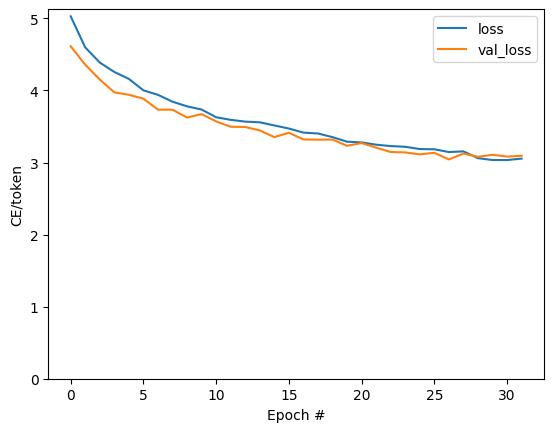

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

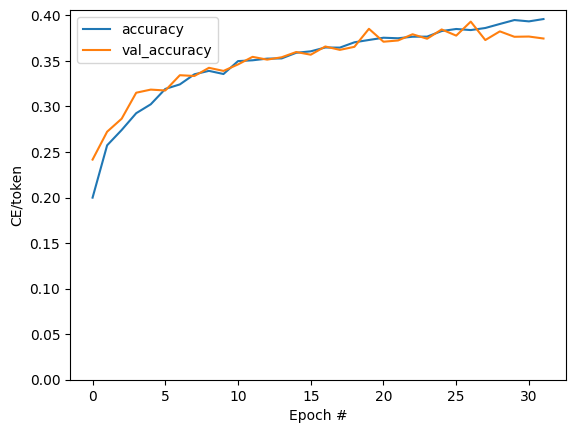

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [56]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a blue shirt is swimming in a wave'

Split the output back into tokens:

In [57]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [58]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 12, 49]), TensorShape([1, 2, 12, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [59]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [60]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        ], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [61]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

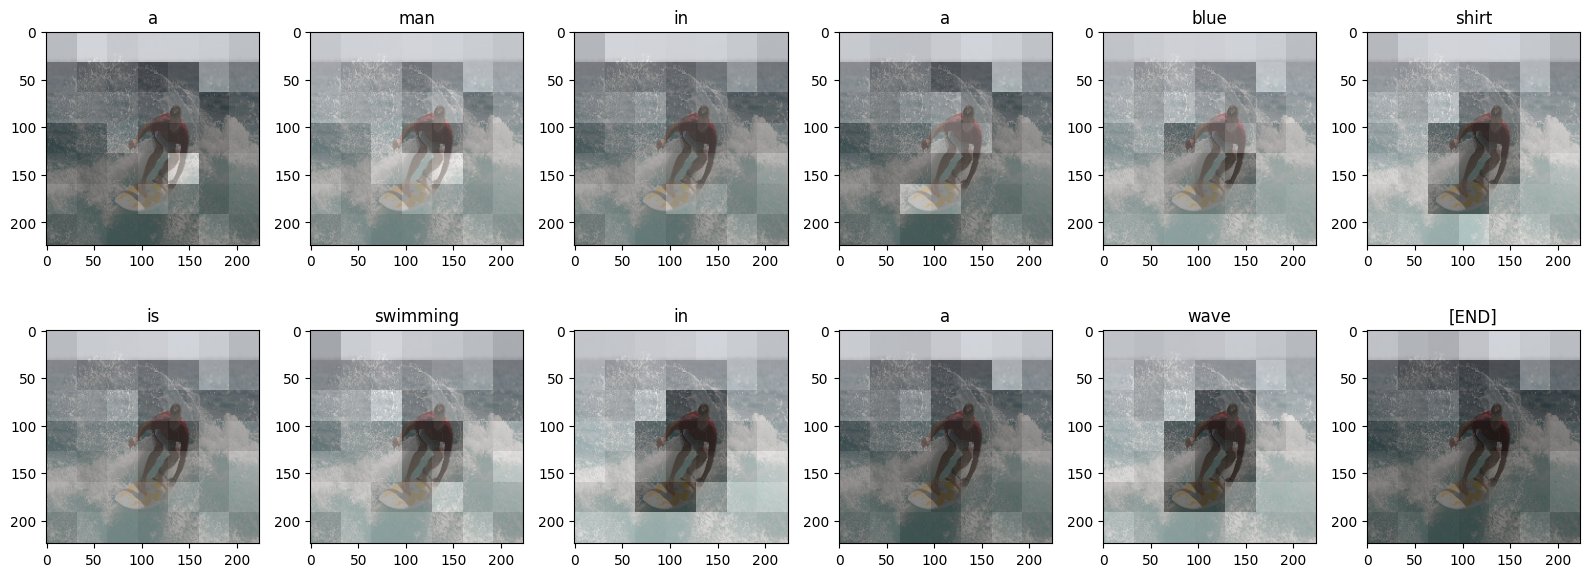

In [62]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [63]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


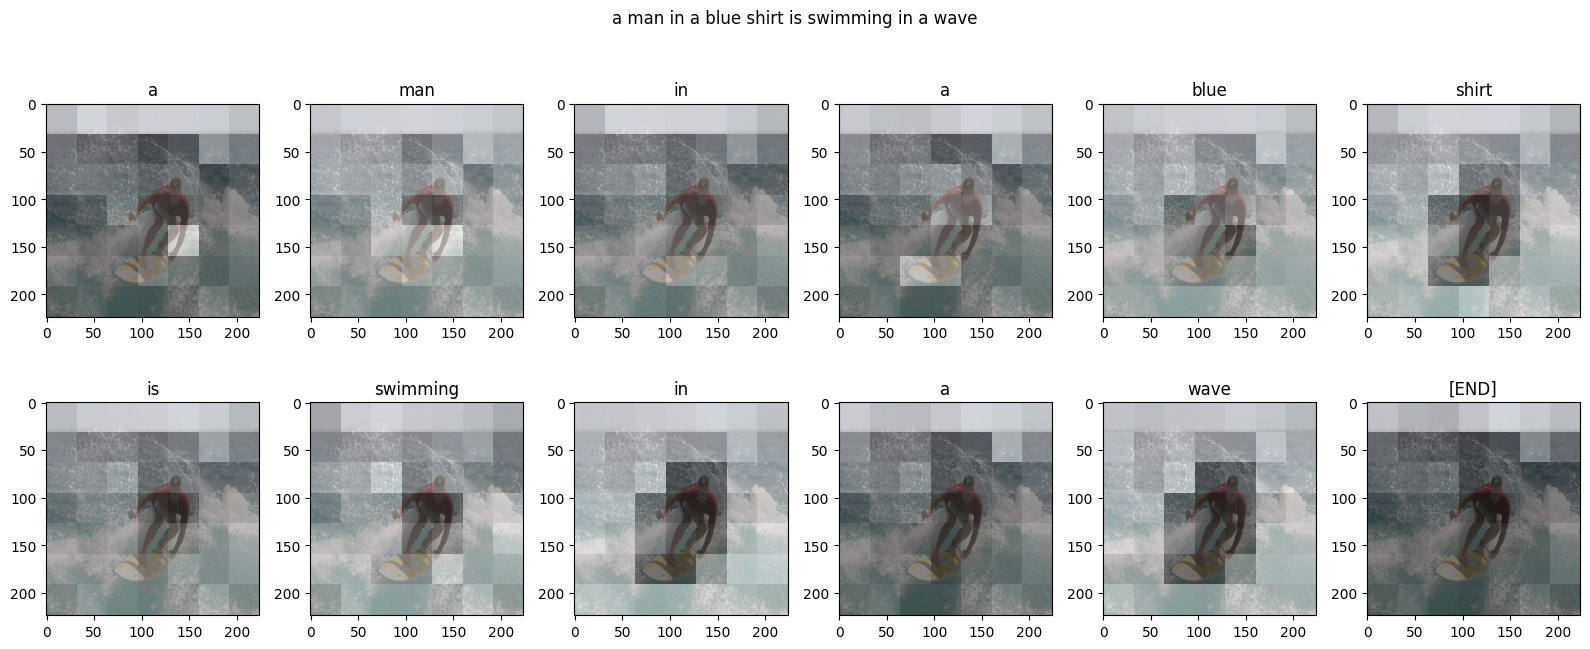

In [64]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


 8192/67460 [==>...........................] - ETA: 0s

49152/67460 [====================>.........] - ETA: 0s

67460/67460 [==============================] - 0s 1us/step


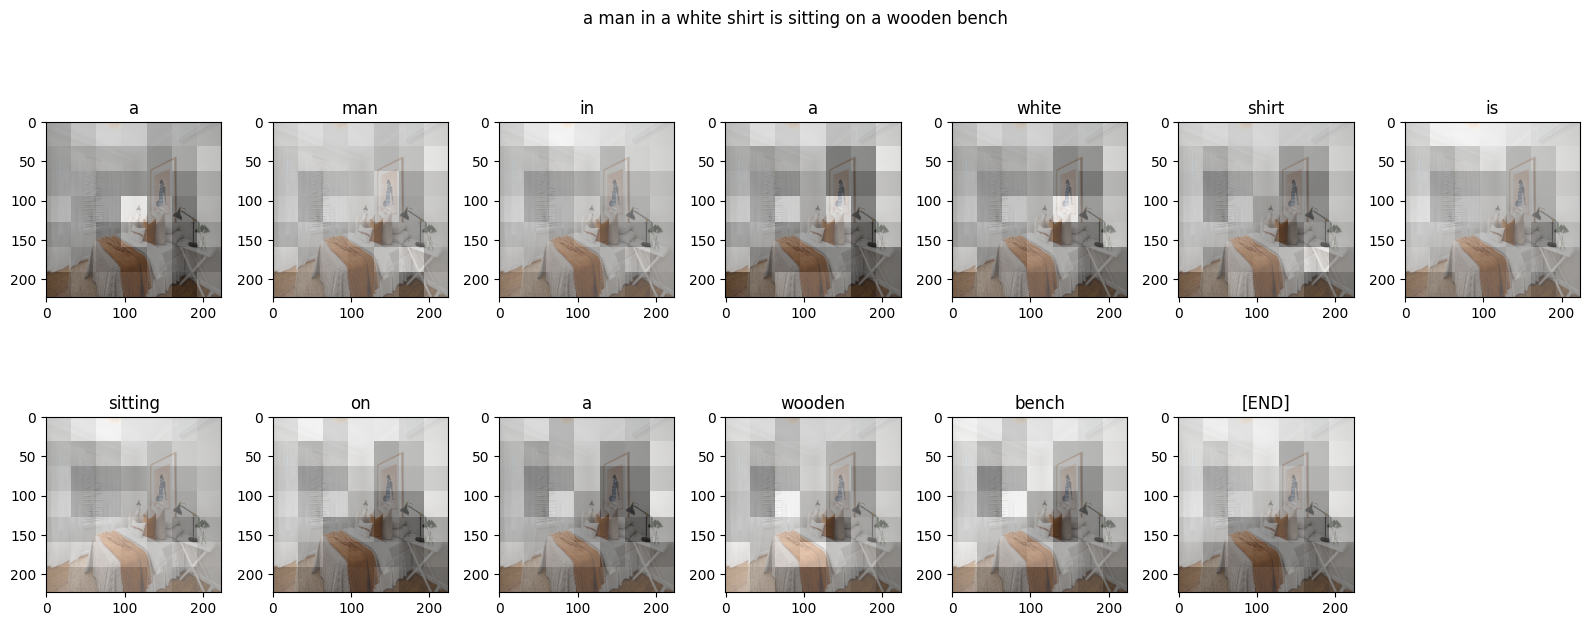

In [65]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)